# Google Cloud & NCAA® ML Competition 2018-Men's

Kaggle Competition Notebook by Alex Herring, Ely Liu, Matthew Prout, Steve Yang

## Business Understanding
***

- What problem are we trying solve?

March Madness is a sports phenomena that centers around the excitement of predicting the outcome of games in the NCAA Men’s Basketball tournament, and the ultimate tournament winner.  Predicting a perfect NCAA bracket is incredibly difficult given there are 9,223,372,036,854,775,808 different possible outcomes (2^63, 9.2 quintillion).  Limited historical data between teams/players and a variety of external factors makes it an even more difficult challenge.

Our task at hand is to leverage machine learning to improve the predictions.

- What are the relevant metrics? How much do we plan to improve them?

Although we provide probabilities for all possible matches, the competition is scored on log-loss of the actual games played, which punishes being both confident and wrong.  A smaller log-loss score is better.  Inputs to the log-loss function include the number of games played, and for each game the predicted probability of team 1 beating team 2 and an indicator variable denoting if team 1 beat or lost to team 2

To measure a baseline, we first set all prediction probabilities to 0.5 -- meaning we determine what the log-loss score is if we make the most uninformative predictions.  This results in a log-loss of 0.69.  We hope to have a log-loss of lower than 0.69.

The prior 3 winners of the competition had an average log-loss of 0.45, but given the number of upsets in this year’s tournament, the winner of the competition this year had a log-loss of 0.53.


- What will we deliver?

Because we must predict the outcomes prior to the start of the tournament, we will not know the actual matchups and we will need to deliver predicted probabilities for every potential matchup of teams in the tournament. To be specific, we provide 2,278 unique matchups with predicted probability that the first team listed will win. The first team is defined as the team with the lower team ID.



## Data Understanding
***

- What are the raw data sources?

A large variety of data was provided by Kaggle (1985 to 2018, except for 2018 tournament results which we scraped ourselves)
Team information, including first and last year in Division I
Season information (year the tournament was played), including first day as well as region
Tournament Seeds
Detailed Game Results for Regular Season Games including key summary statistics
Detailed Game Results for Tournament Games including key summary statistics
Geographic information of the game locations
Day-by-Day Team Rankings from multiple ranking systems
Play-by-play details for each game
Coach information

- The following are detailed description of the datasets we found most pertinent and have been explored, analyzed, or modeled.

    - NCAATourneySeeds.csv
        - Each row represent a team for a particular season
        - Key columns:
            - Season: the year that the tournament was played in
            - Seed: this is a 3/4-character identifier of the seed, where the first character is either W, X, Y, or Z (identifying the region the team was in) and the next two digits (either 01, 02, ..., 15, or 16) tells you the seed within the region.  We stripped the Region info for our analysis
            - TeamID: this identifies the id number of the team
    - RegularSeasonDetailedResults.csv
        - Each row has team summary statistics of each regular season game since 2002-2003 season
        - Key columns:
            - Season: this is the year of the associated entry
            - DayNum: this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date. 
            - WTeamID: this identifies the id number of the team that won the game
            - WScore: this identifies the number of points scored by the winning team
            - LTeamID: this identifies the id number of the team that lost the game
            - LScore: this identifies the number of points scored by the losing team
            - WFGM - field goals made (by the winning team)
            - WFGA - field goals attempted (by the winning team)
            - WFGM3 - three pointers made (by the winning team)
            - WFGA3 - three pointers attempted (by the winning team)
            - WFTM - free throws made (by the winning team)
            - WFTA - free throws attempted (by the winning team)
            - WOR - offensive rebounds (pulled by the winning team)
            - WDR - defensive rebounds (pulled by the winning team)
            - WAst - assists (by the winning team)
            - WTO - turnovers committed (by the winning team)
            - WStl - steals (accomplished by the winning team)
            - WBlk - blocks (accomplished by the winning team)
            - WPF - personal fouls committed (by the winning team)
            - (and then the same set of stats from the perspective of the losing team: LFGM is the number of field goals made by the losing team, and so on up to LPF).
    - NCAATourneyDetailedResults.csv
        - Each row has team summary statistics of each tournament game since 2002-2003 season
        - Key columns:
            - Season: this is the year of the associated entry
            - DayNum: this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date. 
            - WTeamID: this identifies the id number of the team that won the game
            - WScore: this identifies the number of points scored by the winning team
            - LTeamID: this identifies the id number of the team that lost the game
            - LScore: this identifies the number of points scored by the losing team
            - WFGM - field goals made (by the winning team)
            - WFGA - field goals attempted (by the winning team)
            - WFGM3 - three pointers made (by the winning team)
            - WFGA3 - three pointers attempted (by the winning team)
            - WFTM - free throws made (by the winning team)
            - WFTA - free throws attempted (by the winning team)
            - WOR - offensive rebounds (pulled by the winning team)
            - WDR - defensive rebounds (pulled by the winning team)
            - WAst - assists (by the winning team)
            - WTO - turnovers committed (by the winning team)
            - WStl - steals (accomplished by the winning team)
            - WBlk - blocks (accomplished by the winning team)
            - WPF - personal fouls committed (by the winning team)
            - (and then the same set of stats from the perspective of the losing team: LFGM is the number of field goals made by the losing team, and so on up to LPF).
    - MasseyOrdinals.csv
        - Each row represent a rank for a particular per team/season/day/ranking system
        - Key columns:
            - Season - this is the year of the associated entry
            - RankingDayNum - this integer always ranges from 0 to 133, and is expressed in the same terms as a game's DayNum. 
            - SystemName - this is the (usually) 3-letter abbreviation for each distinct ranking system.
            - TeamID - this is the ID of the team being ranked
            - OrdinalRank - this is the overall ranking of the team in the underlying system.


## EDA
***

### EDA: Summary

Before beginning to model our data, we performed exploratory data analysis on some of the existing dataset features as well as our newly generated features.  The following sections will give an overview of the process we used to get a high-level feel for our data before drilling down into individual features.  This includes indentifying features that are highly correlated with each other, and then examining the distrubtions for individual features, interesting discoveries, and the correlation of individual features with the outcome of a game.  Early on in our work, we anticipated features that are highly correlated with game outcome to have the biggest impact on modeling.  The actual results of our modeling will be discussed later in a separate section.  We have included exploratory data analysis on additional features that had relatively lower correlations with game outcome in our appendix.

### EDA: Import

In [12]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# display multiple outputs, default is 'last_expr' (last expression)
# http://ipython.readthedocs.io/en/stable/config/options/terminal.html
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa
import psycopg2 as pg
import seaborn as sns

from psycopg2.extras import execute_values

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.stats import zscore

### EDA: Pulling-Down All the Features From Postgres DB

In [33]:
query = '''SELECT * FROM prod.features WHERE "Season" != 2018'''

conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

df = pd.read_sql_query(query, conn)
conn.close()

### EDA: Taking a High-Level Overview of the Data

In [40]:
pd.set_option('display.max_columns', 100)
df.head()

,Season,DayNum,Team,Opponent,Outcome,Score,OpponentScore,NumOT,WLoc,Season Type,holdout_s1,holdout_s2,AvgRank,OpponentAvgRank,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,TwoPointPct_Opponent,ThreePointPct_Opponent,FreeThrowPct_Opponent,OffensiveRebounds_Opponent,DefensiveRebounds_Opponent,WinPct,OpponentWinPct,WinPctDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,SeedDiff,OpponentAvgPointsFor,OpponentAvgPointsAgainst,OpponentAvgNetPointsFor,TourWins,OpponentTourWins,TourWinsDiff,cum_wins_v_opp,cum_games_v_opp,cum_winpct_v_opp,FieldGoalPct_Team,TwoPointAttPct_Team,ThreePointAttPct_Team,FieldGoalAtt_Team,TwoPointAtt_Team,ThreePointAtt_Team,FreeThrowAtt_Team,Assists_Team,Turnovers_Team,Steals_Team,Blocks_Team,PersonalFouls_Team,FieldGoalPct_Opponent,TwoPointAttPct_Opponent,ThreePointAttPct_Opponent,FieldGoalAtt_Opponent,TwoPointAtt_Opponent,ThreePointAtt_Opponent,FreeThrowAtt_Opponent,Assists_Opponent,Turnovers_Opponent,Steals_Opponent,Blocks_Opponent,PersonalFouls_Opponent
0,2003,14,1166,1202,1,82,57,0,H,Regular,NaN,NaN,NaN,NaN,0.590909,0.600000,0.692308,15.0,29.0,0.578947,0.538462,0.818182,6.0,21.00,1.0,1.0,0.0,106.0,50.0,56.0,NaN,74.0,73.00,1.00,3.0,0.0,3.0,0.0,0.0,NaN,0.594203,0.637681,0.362319,69.0,44.0,25.0,13.0,21.0,11.0,10.0,6.0,16.0,0.568627,0.745098,0.254902,51.00,38.00,13.0,11.00,18.0,15.0,7.0,1.0,5.0
1,2003,20,1234,1194,1,79,52,0,H,Regular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.415801,0.371741,0.609618,13.0,22.25,NaN,0.5,NaN,NaN,NaN,NaN,NaN,70.5,76.75,-6.25,14.0,0.0,14.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.407950,0.774516,0.225484,63.75,49.25,14.5,21.75,11.0,16.5,13.0,2.5,27.0
2,2003,20,1105,1435,0,40,68,0,H,Regular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.684211,0.416667,0.619048,7.0,28.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,80.0,58.00,22.00,0.0,4.0,-4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.620000,0.760000,0.240000,50.00,38.00,12.0,21.00,21.0,22.0,9.0,4.0,21.0
3,2003,20,1405,1243,1,58,50,0,N,Regular,NaN,NaN,NaN,NaN,0.393939,0.263158,0.652174,11.0,18.0,0.409091,0.375000,0.612903,8.0,21.00,0.0,0.0,0.0,56.0,71.0,-15.0,NaN,64.0,73.00,-9.00,0.0,4.0,-4.0,0.0,0.0,NaN,0.346154,0.634615,0.365385,52.0,33.0,19.0,23.0,7.0,17.0,4.0,6.0,22.0,0.403846,0.846154,0.153846,52.00,44.00,8.0,31.00,9.0,10.0,6.0,4.0,23.0
4,2003,21,1164,1326,0,51,58,0,H,Regular,NaN,NaN,NaN,NaN,0.398674,0.361111,0.863636,7.5,16.5,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,50.5,63.5,-13.0,NaN,NaN,NaN,NaN,1.0,14.0,-13.0,0.0,0.0,NaN,0.385882,0.643529,0.356471,50.5,32.5,18.0,6.5,11.5,13.5,4.5,1.0,16.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
pd.set_option('display.max_rows', 100)
df.shape
df.describe().T

(155234, 64)

,count,mean,std,min,25%,50%,75%,max
Season,155234.0,2.010221e+03,4.278759,2003.000000,2007.000000,2010.000000,2014.000000,2017.000000
DayNum,155234.0,7.225313e+01,35.818421,0.000000,40.000000,75.000000,103.000000,154.000000
Team,155234.0,1.284597e+03,104.473843,1101.000000,1194.000000,1283.000000,1376.000000,1464.000000
Opponent,155234.0,1.284597e+03,104.473843,1101.000000,1194.000000,1283.000000,1376.000000,1464.000000
Outcome,155234.0,5.000000e-01,0.500002,0.000000,0.000000,0.500000,1.000000,1.000000
Score,155234.0,6.901533e+01,12.533466,20.000000,60.000000,69.000000,77.000000,144.000000
OpponentScore,155234.0,6.901533e+01,12.533466,20.000000,60.000000,69.000000,77.000000,144.000000
NumOT,155234.0,7.252277e-02,0.314617,0.000000,0.000000,0.000000,0.000000,6.000000
holdout_s1,1962.0,2.731906e-01,0.445712,0.000000,0.000000,0.000000,1.000000,1.000000
holdout_s2,1962.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Score, Win Percentage, & Historical Points Differential

Predictably, winners on average score more than the losers.

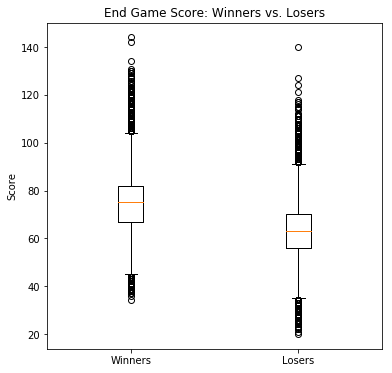

In [107]:
df_winners = df[df.Outcome == 1]
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('End Game Score: Winners vs. Losers')
_ = plt.boxplot([df_winners.Score.dropna(),df_winners.OpponentScore.dropna()])
_ = ax1.set_ylabel('Score')
_ = ax1.set_xticklabels(['Winners','Losers'])

Next, let's look at winning percentage.  This percentage updates after each game played in the season.  Winning percentage is pretty normally distributed except for several noteable spikes.  The spikes in the histogram is caused by the games earlier in the season (i.e. teams losing/winning all of their initial games).

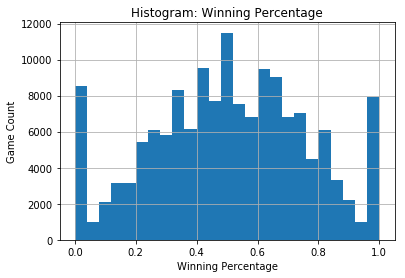

In [108]:
df.WinPct.hist(bins=25)

graph = plt.title('Histogram: Winning Percentage')
graph = plt.xlabel('Winning Percentage')
graph = plt.ylabel('Game Count')

Since winning by 1 point is not the same as blowing out a team and winning by 20, we also looked at the average point differential.  As you can see in the chart below, a team with > 50% win percentage can still have a negative average point differential if they got blown out the few times they lost.  

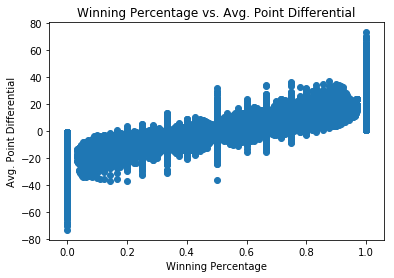

In [109]:
_ = plt.scatter(df.WinPct,df.AvgNetPointsFor)

graph = plt.title('Winning Percentage vs. Avg. Point Differential')
graph = plt.xlabel('Winning Percentage')
graph = plt.ylabel('Avg. Point Differential')

For win percentage and historical score differential, we have a column for the team's current win percentage and their opponent's current win percentage, and a difference in the win percentages.  We have a similar set up for historical score differential as well.  Since the difference columns is a simple subtraction of the team's stats with the opponent's stats, there's a positive correlation between the team's stats with the difference and a negative correlation between the opponent's stats.

As noted above, there's also a correlation between win percentage and the team's historical points differential.

#### Correlation Matrix

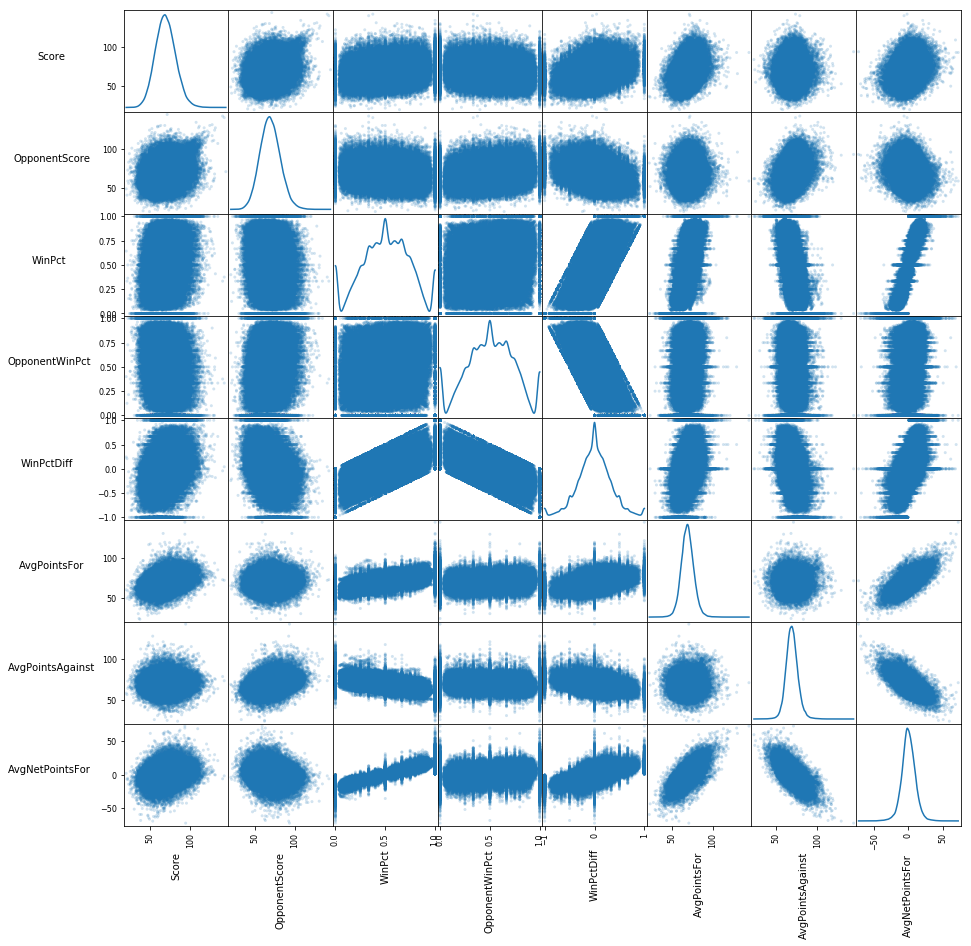

In [110]:
target = ['Outcome']
features = ['Score', 'OpponentScore',
            'WinPct', 'OpponentWinPct', 'WinPctDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

axs = pd.plotting.scatter_matrix(df[features], alpha=0.2, figsize=(15, 15), diagonal='kde')

n = len(df[features].columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

Since Score and OpponentScore is the determinant of Outcome, it's natural that they correlate relatively high to Outcome.  Aside from those features, difference in the team's current win percentages and difference in the team's historical point differential seem to be the highest correlated features.  To limit multi-collinearity between independent variables, we want to limit the use of pairs / sets of variables that show a linear relationshp with one another.

In [32]:
target = ['Outcome']
features = ['Score', 'OpponentScore',
            'WinPct', 'OpponentWinPct', 'WinPctDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

cm = df[target+features].corr()['Outcome'].abs().sort_values(ascending=False)
cm_pretty = pd.DataFrame(cm)
cm_pretty

,Outcome
Outcome,1.000000
OpponentScore,0.477333
Score,0.477333
WinPctDiff,0.395580
AvgNetPointsFor,0.264721
WinPct,0.249926
OpponentWinPct,0.249926
AvgPointsFor,0.193120
AvgPointsAgainst,0.162812


Text(0.5,1,'Correlation Heatmap')

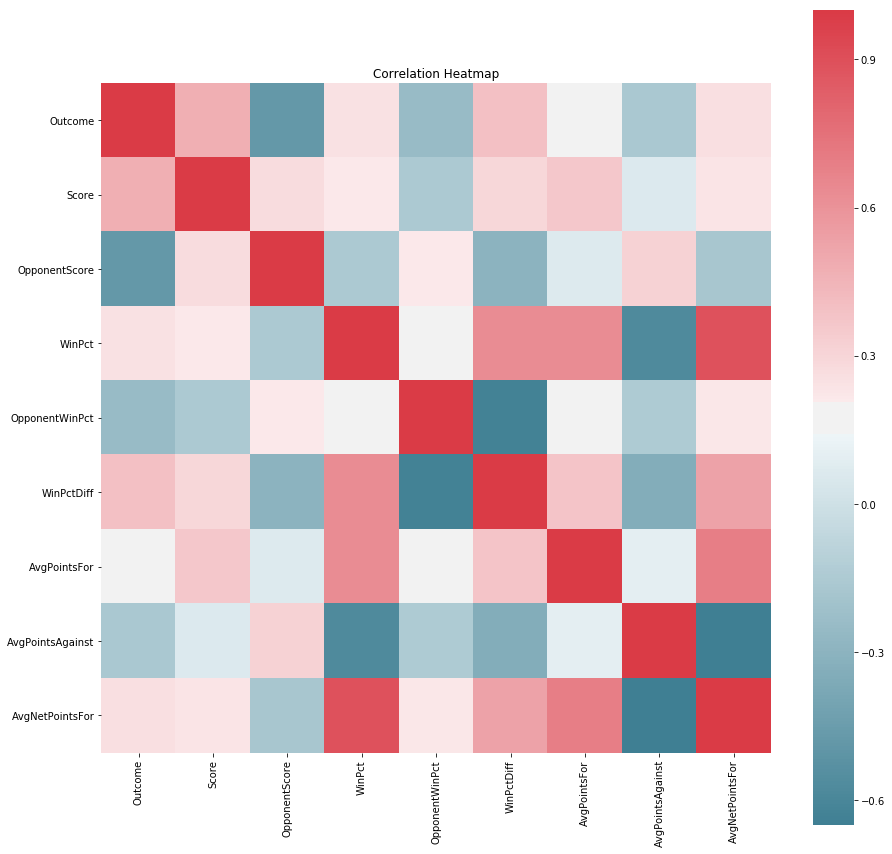

In [105]:
target = ['Outcome']
features = ['Score', 'OpponentScore',
            'WinPct', 'OpponentWinPct', 'WinPctDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

cm = df[target+features].corr()

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(cm, mask=np.zeros_like(cm, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

plt.title('Correlation Heatmap')

### Game Statistics

Kaggle provided statistics about every NCAA division 1 game played between the 2003 and 2018 seasons, inclusive, in the RegSeasonDetailedResults csv file.  

RegSeasonDetailedResults has the following fields.  The 'W' means the winning team, and there is a similar set for the losing team that starts with 'L':

| Field | Meaning |
|:-----------|:------------|
|WFGM|field goals made|
|WFGA|field goals attempted|
|WFGM3|three pointers made|
|WFGA3|three pointers attempted|
|WFTM|free throws made|
|WFTA|free throws attempted|
|WOR|offensive rebounds|
|WDR|defensive rebounds|
|WAst|assists|
|WTO|turnovers committed|
|WStl|steals|
|WBlk|blocks|
|WPF|personal fouls committed|

The RegSeasonDetailedResults data set did not have two point shooting statistics, so this information had to be calculated by subtracting the total number of three point shots from the total number of field goals.

### Game Statistics: 2pt Field Goal Percentage

### Regular Season

In [14]:
df_reg = df[df['Season Type'] == 'Regular']
df_tour = df[df['Season Type'] == 'NCAA Tourney']

df_reg[['TwoPointPct_Team']].describe()

,TwoPointPct_Team
count,148142.000000
mean,0.482409
std,0.047666
min,0.137931
25%,0.454225
50%,0.482926
75%,0.510896
max,0.933333


In [161]:
df_winners = df_reg[df_reg.Outcome == 1]
df_winners[['TwoPointPct_Team', 'TwoPointPct_Opponent']].describe()

,TwoPointPct_Team,TwoPointPct_Opponent
count,74108.000000,74034.000000
mean,0.491336,0.473472
std,0.046648,0.046995
min,0.166667,0.137931
25%,0.463203,0.446472
50%,0.490899,0.474818
75%,0.518255,0.502111
max,0.875000,0.933333


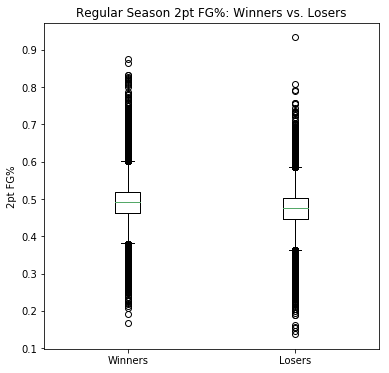

In [160]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Regular Season 2pt FG%: Winners vs. Losers')
_ = plt.boxplot([df_winners.TwoPointPct_Team.dropna(),df_winners.TwoPointPct_Opponent.dropna()])
_ = ax1.set_ylabel('2pt FG%')
_ = ax1.set_xticklabels(['Winners','Losers'])

#### Two Independent Samples T-Test

In [162]:
t, p = ttest_ind(df_winners['TwoPointPct_Team'].dropna(), df_winners['TwoPointPct_Opponent'].dropna(), equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 73.42  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [164]:
df_corr = pd.DataFrame({'Outcome':df_reg['Outcome']})
df_corr['TwoPointDifference'] = df_reg['TwoPointPct_Team'] - df_reg['TwoPointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.28


### Tournament

In [165]:
df_tour[['TwoPointPct_Team']].describe()

,TwoPointPct_Team
count,1962.000000
mean,0.512912
std,0.028199
min,0.416329
25%,0.493646
50%,0.511978
75%,0.529598
max,0.603043


In [167]:
df_winners = df_tour[df_tour.Outcome == 1]
df_winners[['TwoPointPct_Team', 'TwoPointPct_Opponent']].describe()

,TwoPointPct_Team,TwoPointPct_Opponent
count,981.000000,981.000000
mean,0.516378,0.509446
std,0.028102,0.027881
min,0.437311,0.416329
25%,0.495627,0.491635
50%,0.514600,0.509035
75%,0.534131,0.525662
max,0.603043,0.603043


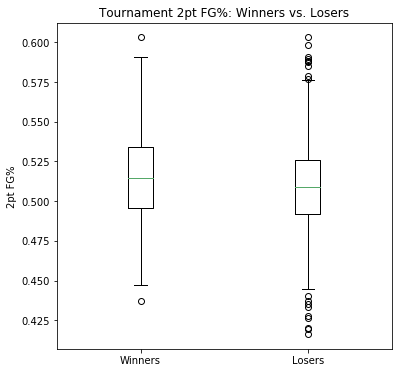

In [168]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Tournament 2pt FG%: Winners vs. Losers')
_ = plt.boxplot([df_winners.TwoPointPct_Team.dropna(),df_winners.TwoPointPct_Opponent.dropna()])
_ = ax1.set_ylabel('2pt FG%')
_ = ax1.set_xticklabels(['Winners','Losers'])

#### Two Independent Samples T-Test

In [169]:
t, p = ttest_ind(df_winners['TwoPointPct_Team'].dropna(), df_winners['TwoPointPct_Opponent'].dropna(), equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 5.48  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [175]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['TwoPointDifference'] = df_tour['TwoPointPct_Team'] - df_tour['TwoPointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.18


### Regular Season vs. Tournament

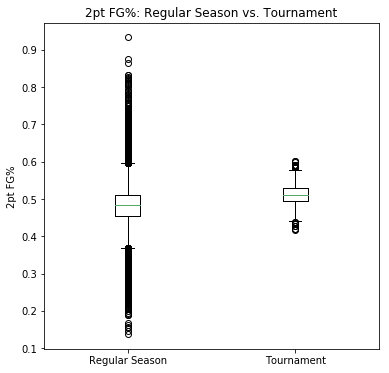

In [176]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('2pt FG%: Regular Season vs. Tournament')
_ = plt.boxplot([df_reg.TwoPointPct_Team.dropna(),df_tour.TwoPointPct_Team.dropna()])
_ = ax1.set_ylabel('2pt FG%')
_ = ax1.set_xticklabels(['Regular Season','Tournament'])

### Analysis

The mean two point shooting percent for the regular season is 48.2% whereas the mean two point shooting percent in the tournament is 51.3%, so the two point shooting percentage is better for tournament teams, which makes sense.  Not only is the mean higher, the variance is also much smaller.

For the regular season, the difference between the mean two point shooting percentage of winning teams (49.1%) v. losing teams (47.3%) is about 2%, and is statistically significant.  The correlation between the difference of the two point shooting of the teams and the outcome of the game (win/lose) is 0.28, which indicates a weak linear relationship.

For the tournament, the difference between the mean two point shooting percentage of winning teams (51.6%) v. losing teams (50.9%) is about 0.7%, which is small, but it is statistically significant.  The correlation between the difference between the two point shooting of the teams and the outcome of the game (win/lose) is 0.18, which indicates a weak linear relationship.

### Game Statistics: 3pt Field Goal Percentage

### Regular Season

In [177]:
df_reg[['ThreePointPct_Team']].describe()

,ThreePointPct_Team
count,148142.000000
mean,0.341386
std,0.048378
min,0.000000
25%,0.314742
50%,0.342090
75%,0.369350
max,0.777778


In [178]:
df_winners = df_reg[df_reg.Outcome == 1]
df_winners[['ThreePointPct_Team', 'ThreePointPct_Opponent']].describe()

,ThreePointPct_Team,ThreePointPct_Opponent
count,74108.000000,74034.000000
mean,0.346192,0.336575
std,0.047837,0.048439
min,0.000000,0.000000
25%,0.319567,0.309940
50%,0.346624,0.337401
75%,0.373706,0.364711
max,0.777778,0.750000


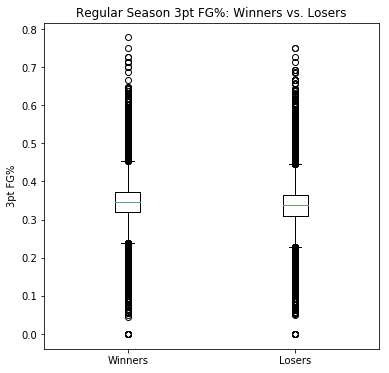

In [179]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Regular Season 3pt FG%: Winners vs. Losers')
_ = plt.boxplot([df_winners.ThreePointPct_Team.dropna(),df_winners.ThreePointPct_Opponent.dropna()])
_ = ax1.set_ylabel('3pt FG%')
_ = ax1.set_xticklabels(['Winners','Losers'])

#### Two Independent Samples T-Test

In [180]:
t, p = ttest_ind(df_winners['ThreePointPct_Team'].dropna(), df_winners['ThreePointPct_Opponent'].dropna(), equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 38.45  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [181]:
df_corr = pd.DataFrame({'Outcome':df_reg['Outcome']})
df_corr['ThreePointDifference'] = df_reg['ThreePointPct_Team'] - df_reg['ThreePointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.15


### Tournament

In [182]:
df_tour[['ThreePointPct_Team']].describe()

,ThreePointPct_Team
count,1962.000000
mean,0.362354
std,0.026914
min,0.262246
25%,0.343863
50%,0.362300
75%,0.380551
max,0.451144


In [183]:
df_winners = df_tour[df_tour.Outcome == 1]
df_winners[['ThreePointPct_Team', 'ThreePointPct_Opponent']].describe()

,ThreePointPct_Team,ThreePointPct_Opponent
count,981.000000,981.000000
mean,0.363691,0.361018
std,0.026325,0.027440
min,0.262246,0.262246
25%,0.345632,0.342500
50%,0.362941,0.361259
75%,0.382606,0.379442
max,0.434708,0.451144


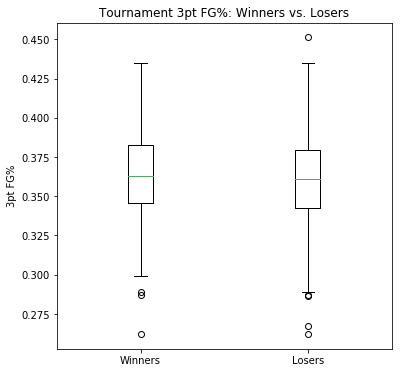

In [184]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Tournament 3pt FG%: Winners vs. Losers')
_ = plt.boxplot([df_winners.ThreePointPct_Team.dropna(),df_winners.ThreePointPct_Opponent.dropna()])
_ = ax1.set_ylabel('3pt FG%')
_ = ax1.set_xticklabels(['Winners','Losers'])

#### Two Independent Samples T-Test

In [185]:
t, p = ttest_ind(df_winners['ThreePointPct_Team'].dropna(), df_winners['ThreePointPct_Opponent'].dropna(), equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 2.20  p = 0.0278


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [186]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['ThreePointDifference'] = df_tour['ThreePointPct_Team'] - df_tour['ThreePointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.07


### Regular Season vs. Tournament

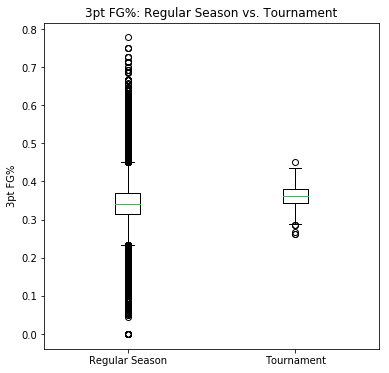

In [187]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('3pt FG%: Regular Season vs. Tournament')
_ = plt.boxplot([df_reg.ThreePointPct_Team.dropna(),df_tour.ThreePointPct_Team.dropna()])
_ = ax1.set_ylabel('3pt FG%')
_ = ax1.set_xticklabels(['Regular Season','Tournament'])

### Analysis

The mean three point shooting in the regular season is 34.1% and it is 36.2% during the tournament, so the three point shooting percentage is better for tournament teams, which makes sense. Not only is the mean higher, the variance is also much smaller.

During the regular season, there is less than a 1% difference between the three point shooting of winning and losing teams, and the difference is statistically significant.  The correlation between the difference in team's three point shooting and the outcome of the game has a correlation of 0.15, which is weakly correlated.

During the tournament, there is a 0.2% difference between the three point shooting of winning and losing teams, and the difference is statistically significant at the p=0.05 level.  The correlation between the difference in team's three point shooting and the outcome of the game has a correlation of 0.07, which is very weakly correlated.

Because of the lack of correlation between three point shooting and the outcome of games, this feature will provide little benefit to the model.

### Game Statistics: Offensive Rebounds

### Regular Season

In [200]:
df_reg[['OffensiveRebounds_Team']].describe()

,OffensiveRebounds_Team
count,148142.000000
mean,11.434332
std,2.242420
min,1.000000
25%,10.000000
50%,11.388889
75%,12.750000
max,32.000000


In [201]:
df_winners = df_reg[df_reg.Outcome == 1]
df_winners[['OffensiveRebounds_Team', 'OffensiveRebounds_Opponent']].describe()

,OffensiveRebounds_Team,OffensiveRebounds_Opponent
count,74108.000000,74034.000000
mean,11.565193,11.303340
std,2.264369,2.212508
min,1.000000,1.000000
25%,10.148148,9.920769
50%,11.500000,11.275862
75%,12.875000,12.625000
max,32.000000,29.000000


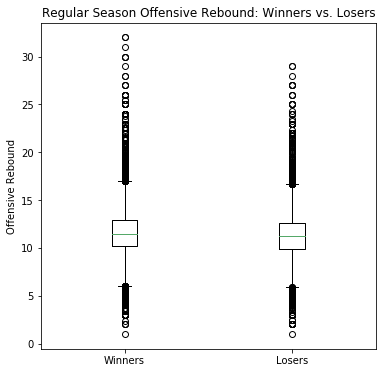

In [202]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Regular Season Offensive Rebound: Winners vs. Losers')
_ = plt.boxplot([df_winners.OffensiveRebounds_Team.dropna(),df_winners.OffensiveRebounds_Opponent.dropna()])
_ = ax1.set_ylabel('Offensive Rebound')
_ = ax1.set_xticklabels(['Winners','Losers'])

#### Two Independent Samples T-Test

In [203]:
t, p = ttest_ind(df_winners['OffensiveRebounds_Team'].dropna(), df_winners['OffensiveRebounds_Opponent'].dropna(), equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 22.51  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [204]:
df_corr = pd.DataFrame({'Outcome':df_reg['Outcome']})
df_corr['OffensiveReboundDifference'] = df_reg['OffensiveRebounds_Team'] - df_reg['OffensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.09


### Tournament

In [205]:
df_tour[['OffensiveRebounds_Team']].describe()

,OffensiveRebounds_Team
count,1962.000000
mean,11.761077
std,1.809222
min,5.468750
25%,10.562231
50%,11.762121
75%,12.966379
max,17.032258


In [206]:
df_winners = df_tour[df_tour.Outcome == 1]
df_winners[['OffensiveRebounds_Team', 'OffensiveRebounds_Opponent']].describe()

,OffensiveRebounds_Team,OffensiveRebounds_Opponent
count,981.000000,981.000000
mean,11.973195,11.548960
std,1.825472,1.768468
min,5.468750,5.468750
25%,10.806452,10.387097
50%,11.878788,11.551724
75%,13.322581,12.700000
max,17.032258,17.032258


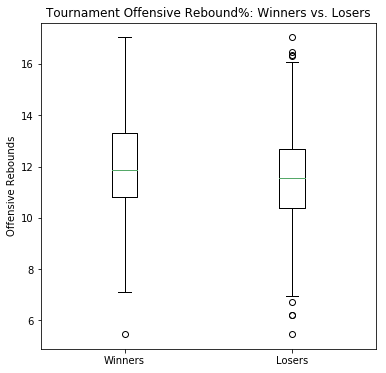

In [207]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Tournament Offensive Rebound %: Winners vs. Losers')
_ = plt.boxplot([df_winners.OffensiveRebounds_Team.dropna(),df_winners.OffensiveRebounds_Opponent.dropna()])
_ = ax1.set_ylabel('Offensive Rebounds')
_ = ax1.set_xticklabels(['Winners','Losers'])

#### Two Independent Samples T-Test

In [208]:
t, p = ttest_ind(df_winners['OffensiveRebounds_Team'].dropna(), df_winners['OffensiveRebounds_Opponent'].dropna(), equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 5.23  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [209]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['OffensiveReboundDifference'] = df_tour['OffensiveRebounds_Team'] - df_tour['OffensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.17


### Regular Season vs. Tournament

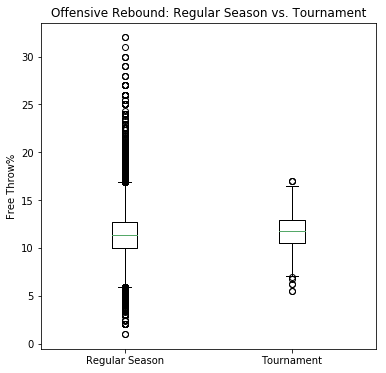

In [210]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Offensive Rebound: Regular Season vs. Tournament')
_ = plt.boxplot([df_reg.OffensiveRebounds_Team.dropna(),df_tour.OffensiveRebounds_Team.dropna()])
_ = ax1.set_ylabel('Free Throw%')
_ = ax1.set_xticklabels(['Regular Season','Tournament'])

### Analysis

The mean offensive rebounds for the regular season is 11.4 whereas the mean offensive rebounds in the tournament is 11.8.  The variance is also smaller.  

For the regular season, the difference between the mean offensive rebounding of winning teams (11.6) v. losing teams (11.3) is about 0.3, and is statistically significant.  The correlation between the offensive rebounding of the teams and the outcome of the game (win/lose) is 0.09, which indicates minimal linear relationship.

For the tournament, the difference between the mean offensive rebounding of winning teams (12.0) v. losing teams (11.5) is about 0.5, and is statistically significant.  The correlation between the offensive rebounding of the teams and the outcome of the game (win/lose) is 0.17, which indicates some linear relationship.

### Game Statistics: Defensive Rebounds

### Regular Season

In [211]:
df_reg[['DefensiveRebounds_Team']].describe()

,DefensiveRebounds_Team
count,148142.000000
mean,23.697589
std,2.734722
min,6.000000
25%,22.000000
50%,23.590909
75%,25.272727
max,48.000000


In [212]:
df_winners = df_reg[df_reg.Outcome == 1]
df_winners[['DefensiveRebounds_Team', 'DefensiveRebounds_Opponent']].describe()

,DefensiveRebounds_Team,DefensiveRebounds_Opponent
count,74108.000000,74034.000000
mean,24.029416,23.365430
std,2.776296,2.651209
min,8.000000,6.000000
25%,22.266667,21.700000
50%,23.913043,23.275862
75%,25.608696,24.937500
max,48.000000,48.000000


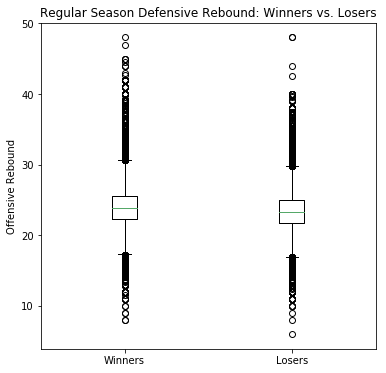

In [213]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Regular Season Defensive Rebound: Winners vs. Losers')
_ = plt.boxplot([df_winners.DefensiveRebounds_Team.dropna(),df_winners.DefensiveRebounds_Opponent.dropna()])
_ = ax1.set_ylabel('Offensive Rebound')
_ = ax1.set_xticklabels(['Winners','Losers'])

#### Two Independent Samples T-Test

In [214]:
t, p = ttest_ind(df_winners['DefensiveRebounds_Team'].dropna(), df_winners['DefensiveRebounds_Opponent'].dropna(), equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 47.07  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [215]:
df_corr = pd.DataFrame({'Outcome':df_reg['Outcome']})
df_corr['DefensiveReboundDifference'] = df_reg['DefensiveRebounds_Team'] - df_reg['DefensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.19


### Tournament

In [216]:
df_tour[['DefensiveRebounds_Team']].describe()

,DefensiveRebounds_Team
count,1962.000000
mean,24.740825
std,1.855590
min,15.370370
25%,23.521860
50%,24.678710
75%,25.939394
max,30.968750


In [217]:
df_winners = df_tour[df_tour.Outcome == 1]
df_winners[['DefensiveRebounds_Team', 'DefensiveRebounds_Opponent']].describe()

,DefensiveRebounds_Team,DefensiveRebounds_Opponent
count,981.000000,981.000000
mean,24.925800,24.555850
std,1.869116,1.824240
min,19.892857,15.370370
25%,23.645161,23.366667
50%,24.968750,24.533333
75%,26.187500,25.714286
max,30.968750,30.968750


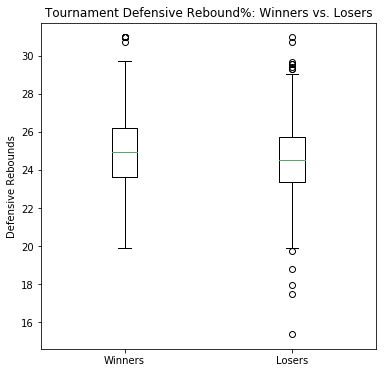

In [218]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Tournament Defensive Rebound%: Winners vs. Losers')
_ = plt.boxplot([df_winners.DefensiveRebounds_Team.dropna(),df_winners.DefensiveRebounds_Opponent.dropna()])
_ = ax1.set_ylabel('Defensive Rebounds')
_ = ax1.set_xticklabels(['Winners','Losers'])

#### Two Independent Samples T-Test

In [219]:
t, p = ttest_ind(df_winners['DefensiveRebounds_Team'].dropna(), df_winners['DefensiveRebounds_Opponent'].dropna(), equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 4.44  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [220]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['DefensiveReboundDifference'] = df_tour['DefensiveRebounds_Team'] - df_tour['DefensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.15


### Regular Season vs. Tournament

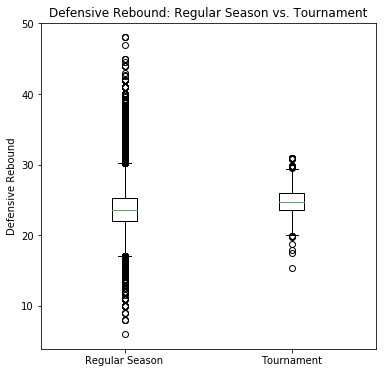

In [222]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Defensive Rebound: Regular Season vs. Tournament')
_ = plt.boxplot([df_reg.DefensiveRebounds_Team.dropna(),df_tour.DefensiveRebounds_Team.dropna()])
_ = ax1.set_ylabel('Defensive Rebound')
_ = ax1.set_xticklabels(['Regular Season','Tournament'])

### Analysis

The mean defensive rebounds for the regular season is 23.7 whereas the mean defensive rebounds in the tournament is 24.7, so the defensive rebounding is better for tournament teams, which makes sense.

For the regular season, the difference between the mean defensive rebounding of winning teams (24.0) v. losing teams (23.4) is about 0.6, and is statistically significant.  The correlation between the defensive rebounding of the teams and the outcome of the game (win/lose) is 0.19, which indicates a weak linear relationship.

For the tournament, the difference between the mean defensive rebounding of winning teams (24.9) v. losing teams (24.6) is about 0.3, and is statistically significant.  The correlation between the defensive rebounding of the teams and the outcome of the game (win/lose) is 0.15, which is a weak linear relationship.

### Game Statistic Relationships

There does not appear to be a linear relationship amongst these game statistics.  Thus, the assumption needed for linear regression of little to no multi-collinearity amongst independent variables is upheld for these variables.

#### Game Statistics Correlation Matrix

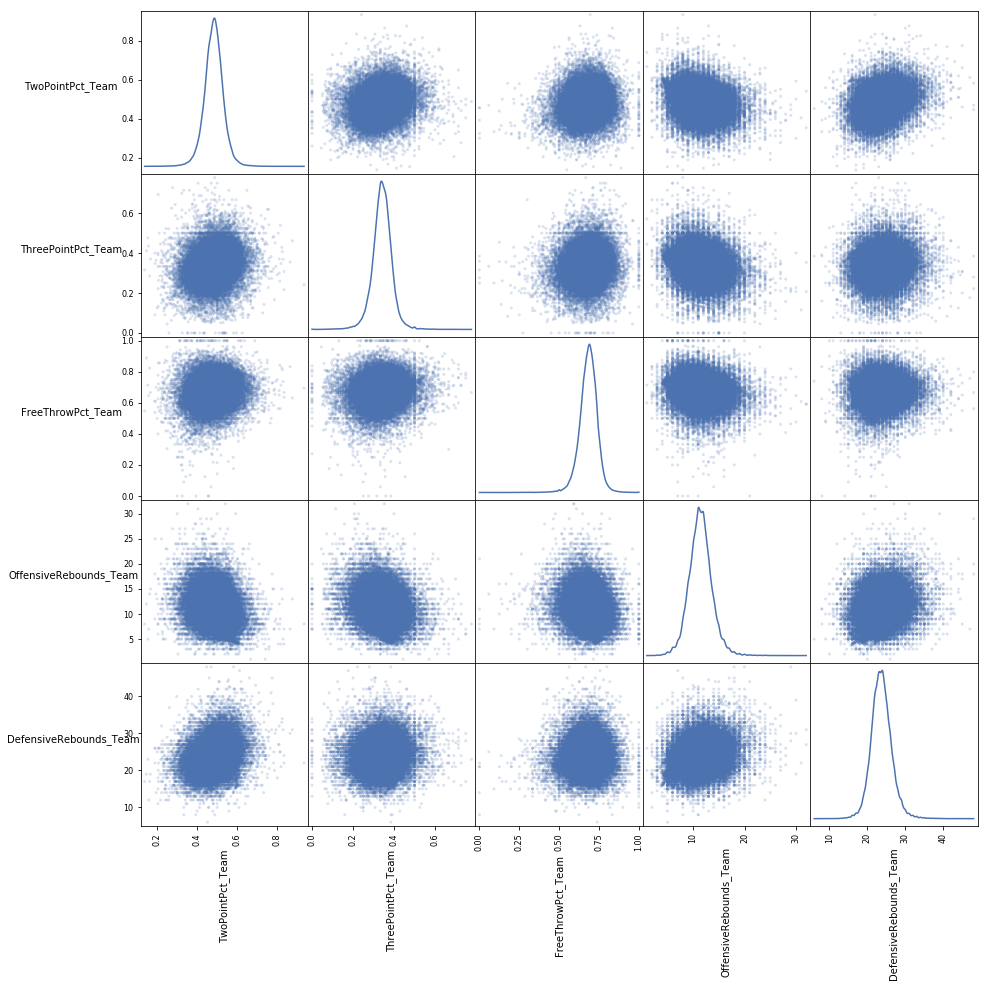

In [223]:
target = ['Outcome']
features = ['TwoPointPct_Team', 'ThreePointPct_Team',
            'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team',
           ]

axs = pd.plotting.scatter_matrix(df[features], alpha=0.2, figsize=(15, 15), diagonal='kde')
n = len(df[features].columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

### Ranking Systems

Although the median rank for tournament games are much lower (24 vs. 167), there are definitely some lower ranked teams making it into the tournament.

In [227]:
df_reg[['AvgRank']].describe()
df_tour[['AvgRank']].describe()

,AvgRank
count,145946.000000
mean,167.646891
std,96.521477
min,1.000000
25%,84.203925
50%,166.500000
75%,250.490000
max,350.868000


,AvgRank
count,1962.000000
mean,39.561237
std,46.695648
min,1.112900
25%,11.186700
50%,23.772700
75%,44.931000
max,278.980000


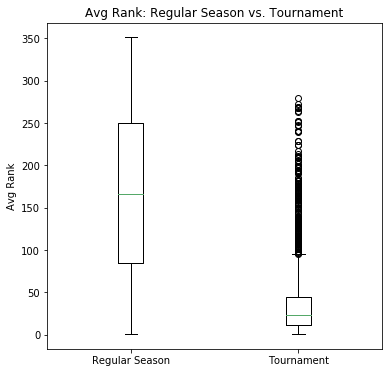

In [228]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Avg Rank: Regular Season vs. Tournament')
_ = plt.boxplot([df_reg.AvgRank.dropna(),df_tour.AvgRank.dropna()])
_ = ax1.set_ylabel('Avg Rank')
_ = ax1.set_xticklabels(['Regular Season','Tournament'])

Rank difference is negatively correlated with the outcome since the lower the rank the better the teams are.

In [226]:
df_corr = pd.DataFrame({'Outcome':df_reg['Outcome']})
df_corr['AvgRankDifference'] = df_reg['AvgRank'] - df_reg['OpponentAvgRank']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: -0.48


In [224]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['AvgRankDifference'] = df_tour['AvgRank'] - df_tour['OpponentAvgRank']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: -0.47


### Seed

As defined by NCAA.com, "68 teams earn bids to the NCAA tournament, and each one receives a seed (from 1 to 16) that determines where the team will be placed in the bracket. After the First Four, there are four of every seed. The seeds are also ranked overall from 1 to 68."

Looking at the tournament games, the winners tend to have lower seeds and the correlation to the outcome is relatively high at -0.5.

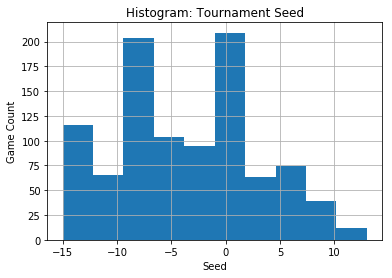

In [83]:
df_winners.SeedDiff.hist()

graph = plt.title('Histogram: Tournament Seed')
graph = plt.xlabel('Seed')
graph = plt.ylabel('Game Count')

In [229]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['SeedDiff'] = df_tour['SeedDiff']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: -0.50


When there's a difference in seed, the higher seed team win 72% of the time

In [231]:
df_winners = df_tour[df_tour.Outcome == 1]
wins = len(df_winners[df_winners.SeedDiff<0])
losses = len(df_winners[df_winners.SeedDiff>0])
print "{0:.0f}%".format(1.*wins/(wins+losses)*100)

72%


Instead of just looking at whether or not a seed is higher, let's look at the actual difference between the seed.  In the chart below, it does look like the larger the seed difference, the win percentage does also go up.  There is an odd drop at seed diff = 10 though.  It's likely due to the low sample size (only 8 games with seed diff of 10).

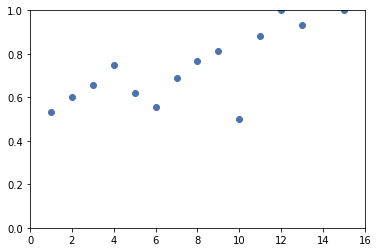

In [233]:
diff_summary = pd.DataFrame(columns=['SeedDiff','WinPercentage','GameCount'])

for diff in range(1,16):
    wins = len(df_winners[df_winners.SeedDiff==-diff])
    losses = len(df_winners[df_winners.SeedDiff==diff])
    if wins+losses != 0:
        temp_df = pd.DataFrame([[diff, 1.*wins/(wins+losses),wins+losses]],columns=['SeedDiff','WinPercentage','GameCount'])
        diff_summary = diff_summary.append(temp_df)

_ = plt.axis((0,16,0,1))
_ = plt.scatter(diff_summary.SeedDiff,diff_summary.WinPercentage)

### Historical Tournament Wins (Legacy)

The number of historical tournament wins ranges from 90 to 0.

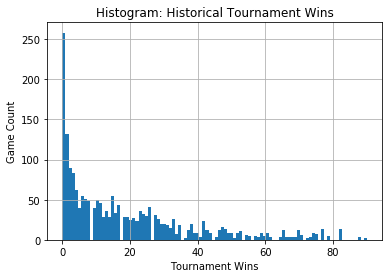

In [82]:
df_tour.TourWins.hist(bins=100)

graph = plt.title('Histogram: Historical Tournament Wins')
graph = plt.xlabel('Tournament Wins')
graph = plt.ylabel('Game Count')

35% of the regular season games the two teams have the same tour wins, so this feature may not be as useful in regular season games.

In [244]:
print 1.0 * len(df_reg[(df_reg.TourWinsDiff==0) & (df_reg.Season!=1985)])/len(df_reg[df_reg.Season!=1985])

0.345738295318


4% of the tournament games the two teams have the same tour wins, so this feature should be useful for tournament games.

In [243]:
print 1.0 * len(df_tour[(df_tour.TourWinsDiff==0) & (df_tour.Season!=1985)])/len(df_tour[df_tour.Season!=1985])

0.0428134556575


The correlation between historical tour wins with regular season games is 0.24 and the same for tournament games is 0.39.

In [246]:
df_corr = pd.DataFrame({'Outcome':df_reg['Outcome']})
df_corr['TourWinsDiff'] = df_reg['TourWinsDiff']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.24


In [245]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['TourWinsDiff'] = df_tour['TourWinsDiff']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.39


Teams with more historical tour wins have 70% of winning

In [248]:
df_winners = df_tour[df_tour.Outcome == 1]
wins = len(df_winners[df_winners.TourWinsDiff>0])
losses = len(df_winners[df_winners.TourWinsDiff<0])
print "{0:.0f}%".format(1.*wins/(wins+losses)*100)

70%


The bigger the difference in historical tournament wins, the bigger the chance the team with better legacy will win.  For example, if team A has 30 more historical tournament wins than their opponent, they will have 80.8% chance of winning.

In [85]:
def winPercentageByTourWinDiff(tWinDiff):
    wins = len(df_winners[df_winners.TourWinsDiff>tWinDiff])
    losses = len(df_winners[df_winners.TourWinsDiff<-tWinDiff])
    return 1.*wins/(wins+losses), wins+losses

tourwin_diff_summary = pd.DataFrame(columns=['TourWinDiff','WinPercentage','GameCount'])
win_diff_list = [0,5,10,15,20,25,30,35,40,45,50,55,60,70,75]
for d in win_diff_list:
    temp_df = pd.DataFrame([[d, winPercentageByTourWinDiff(d)[0], winPercentageByTourWinDiff(d)[1]]],columns=['TourWinDiff','WinPercentage','GameCount'])
    tourwin_diff_summary = tourwin_diff_summary.append(temp_df)
    
tourwin_diff_summary

,TourWinDiff,WinPercentage,GameCount
0,0,0.657452,51079
0,5,0.729684,20661
0,10,0.752326,14616
0,15,0.772754,10372
0,20,0.795625,7452
0,25,0.816081,5062
0,30,0.820635,3557
0,35,0.837087,2664
0,40,0.845973,2123
0,45,0.855466,1619


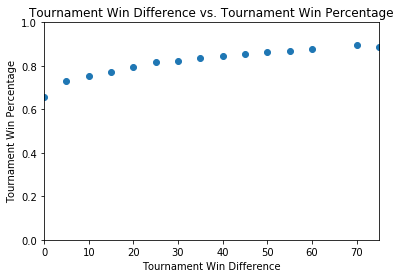

In [89]:
_ = plt.axis((0,75,0,1))
_ = plt.scatter(tourwin_diff_summary.TourWinDiff,tourwin_diff_summary.WinPercentage)

graph = plt.title('Tournament Win Difference vs. Tournament Win Percentage')
graph = plt.xlabel('Tournament Win Difference')
graph = plt.ylabel('Tournament Win Percentage')

### Game Statistics: Cumulative Win Percent vs. Opponent

This feature looks at the cumulative win percent before a given day vs. a particular opponent (since 2003).

### Regular Season

In [96]:
df_reg[['cum_winpct_v_opp']].describe()

,cum_winpct_v_opp
count,128500.000000
mean,0.500000
std,0.311968
min,0.000000
25%,0.285714
50%,0.500000
75%,0.714286
max,1.000000


In [97]:
se_reg = float(np.std(df_reg[['cum_winpct_v_opp']])) / ((len(df_reg[['cum_winpct_v_opp']])) ** (0.5))

print "The standard error is: ", se_reg

The standard error is:  0.000770154807361


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACB7B1D390>]],
      dtype=object)

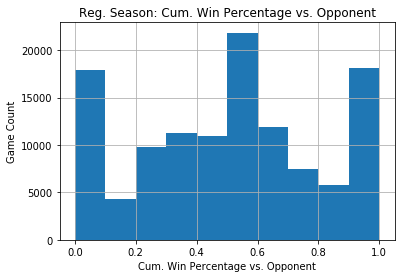

In [93]:
df_reg[['cum_winpct_v_opp']].hist()

graph = plt.title('Reg. Season: Cum. Win Percentage vs. Opponent')
graph = plt.xlabel('Cum. Win Percentage vs. Opponent')
graph = plt.ylabel('Game Count')

#### Correlation Between Cumulative Win Percentage vs. Opponent and Outcome

In [99]:
df_corr = pd.DataFrame({'Outcome':df_reg['Outcome']})
df_corr['cum_winpct_v_opp'] = df_reg['cum_winpct_v_opp']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0, 1])

The correlation is: 0.25


### Tournament

In [100]:
df_tour[['cum_winpct_v_opp']].describe()

,cum_winpct_v_opp
count,2482.00000
mean,0.50000
std,0.41623
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [101]:
se_tour = float(np.std(df_tour[['cum_winpct_v_opp']])) / ((len(df_tour[['cum_winpct_v_opp']])) ** (0.5))

print "The standard error is: ", se_tour

The standard error is:  0.0051545314857


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACB7D68908>]],
      dtype=object)

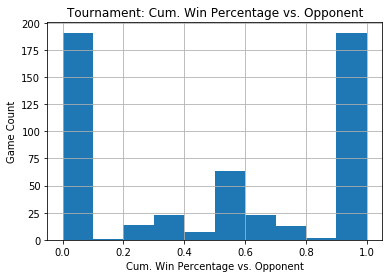

In [94]:
df_tour[['cum_winpct_v_opp']].hist()

graph = plt.title('Tournament: Cum. Win Percentage vs. Opponent')
graph = plt.xlabel('Cum. Win Percentage vs. Opponent')
graph = plt.ylabel('Game Count')

#### Correlation Between Cumulative Win Percentage vs. Opponent and Outcome

In [104]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['cum_winpct_v_opp'] = df_tour['cum_wins_v_opp']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0, 1])

The correlation is: 0.04


### Regular Season vs. Tournament

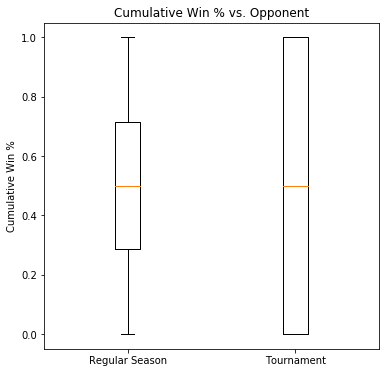

In [105]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Cumulative Win % vs. Opponent')
_ = plt.boxplot([df_reg.cum_winpct_v_opp.dropna(), df_tour.cum_winpct_v_opp.dropna()])
_ = ax1.set_ylabel('Cumulative Win %')
_ = ax1.set_xticklabels(['Regular Season','Tournament'])

### Analysis

The mean cumulative wins since 2003 vs. a particular opponent in the regular season is 0.5, and is also 0.5 during the tournament.  As combinations of teams are included from the winning perspective and losing perspective, (i.e. data for team A vs. team B, and team B vs. team A), this makes sense.

Both the regular season and tournament data shows some signs of normality around the mean, but both have significant upward skew for lower and higher win percents.  This makes sense as there are a large number of teams that have only played each other a few times, and have had a large percent of wins or losses vs. each other during these matchups.

The increase in standard error from the regular season (0.0008) to the tournament (0.005) is due primarily to the effect of the smaller sample size of the tournament vs. the regular season outweighing the effect of the smaller standard deviation of the tournament vs. the regular season.

Because of the small degree of correlation between the cumulative wins vs. a particular opponent and the outcome of games (0.25 for the regular season, and 0.04 for the tournament), this feature will provide little benefit to the model.

## Data Preparation / Feature Engineering
***

### Data Preparation Challenges

We faced a number of challenges related to data preparation and feature engineering. Unlike many projects we've faced previously or a typical Kaggle competition, we had to make careful assumptions on what exactly would comprise the training dataset. One reason, as made apparent in the data understanding section, was due to the number of datasets available. Three other primary reasons, made this process rather challenging.

First, the predictions were not based on features of that game itself. That is, it'd be rather useless if we used the features of a specific game to predict the outcome of that same game, since at prediction time that data would be unavailable. Thus, we had to engineer features that would be available to use at prediction time, making this a time-series forecasting problem in addition to simply a prediction problem.

The second challenge was keeping clear what feature would and would not be available at prediction time. There were a number of features that seemed great retrospectively, but we had to limit ourselves to features that would be available before the tournament began.

Finally, there were two main approaches to modeling, which caused challenges to the data preparation. Approach 1 involved using only the tournament results as the target variables, although it was still possible to engineer features that retained information about the regular season. The theory behind this approach was the hypothesis that regular season games and tournament games would be heterogenous. The implication of this approach were much fewer observations, but ones that would be more relevant to the prediction. Also, there were features that would not be possible to have if we trained based on regular season games -- primarily tournament seeds. Approach 2 took into account all regular season games. In this approach we theorized that tournament games were merely an extension of regular season games, and learning on the regular season could be used to predict the tournament results. The two approaches warranted slightly different logic for feature engineering, details of which are outlined below.

### Data Preparation Solutions

To handle some of the challenges, we set up a PostgreSQL instance of Google Cloud Platform to ensure we would be working with a single version of the truth. This was especially important because of the number of data sources and variations in features as mentioned above.

We build the canonical features table in which each row is one of the teams in every regular season or tournament game. In other words, there are two rows for every game, each row corresponding to one of two teams that play in that game. Each row also contains information about the opponent and features about the opponent, since how likely a team is to win a game is dependent just as much on the opponent they are facing. The target variable is, of course, game outcome represented as a binary variable. The modeling table begins with the 2003 season due to data quality issues before that time period for a number of raw data sources.

We create an extensive list of features -- some of which are simple aggregations of game statistics, and others based on more complex logic. The details of each feature can be found in this [document](http://www.google.com). There are some overarching patterns for the majority of the features.

First, most features are created in sets of three. That feature as it applies to the team, the opponent, and the difference between team and opponent. For example, for each row we would have the features "Two Point Percentage", "Opponent Two Point Percentage", and "Two Point Percentage Difference". 

Another nuance of feature engineering is that each feature is only compiled of information from preceding games from the season. Using "Two Point Percentage" as an example again. The feature is NaN in the first game of the season, since there is no preceding game. The second game of the season would be the metric from the previous game. For the third game of the season, the metric would be the aggregate from the first two games; and so on. For the tournament games, the feature is an aggregate of all games from the regular season. Described more concisely, we take cumulative aggregates of all metrics. This is to ensure that there is no data leakage.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as pg
import csv

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Modeling - Approach 1
***

In our first approach to modeling, we made the fundamental assumption that regular season results were not a representative population for tournament games. This meant although we had interesting information at an individual game level, we had to aggregate the unit of analysis for each season.

More specifically, in our first approach, we carried-over the season-level aggregate metrics into the tournament period. That is, if Team A played 3 games in the tournament, the feature, "Two Point Shooting Percentage", for example, would be the same aggregated metric based on the regular season games. 

There is a row for each team who plays in a tournament game between 2003 and 2013 for the training data. The dev data are the same for games in 2014 to 2017. This corresponds to Stage 1 of the Kaggle competition.

### Pull Features from PostgreSQL

Pull data from PostgreSQL and save to CSV. Basically saving data pull locally for when we bring down GCP instance

In [2]:
# query = '''
#     SELECT *
#     FROM prod.features
#     WHERE "Season Type" = 'NCAA Tourney' and
#         holdout_s2 = 0
# '''

# conn = pg.connect(database='postgres',
#                   user='postgres',
#                   password='w207final',
#                   host='35.185.225.167')

# df = pd.read_sql_query(query, conn)

# # "Diff" Features
# df['AvgRankDiff'] = df['AvgRank'] - df['OpponentAvgRank']
# df['AvgNetPointsForDiff'] = df['AvgNetPointsFor'] - df['OpponentAvgNetPointsFor']
# df['TwoPointPctDiff'] = df['TwoPointPct_Team'] - df['TwoPointPct_Opponent']
# df['ThreePointPctDiff'] = df['ThreePointPct_Team'] - df['ThreePointPct_Opponent']
# df['FreeThrowPctDiff'] = df['FreeThrowPct_Team'] - df['FreeThrowPct_Opponent']
# df['OffensiveReboundsDiff'] = df['OffensiveRebounds_Team'] - df['OffensiveRebounds_Opponent']
# df['DefensiveReboundsDiff'] = df['DefensiveRebounds_Team'] - df['DefensiveRebounds_Opponent']
# df['FieldGoalPctDiff'] = df['FieldGoalPct_Team'] - df['FieldGoalPct_Opponent']
# df['TwoPointAttPctDiff'] = df['TwoPointAttPct_Team'] - df['TwoPointAttPct_Opponent']
# df['ThreePointAttPctDiff'] = df['ThreePointAttPct_Team'] - df['ThreePointAttPct_Opponent']
# df['FieldGoalAttDiff'] = df['FieldGoalAtt_Team'] - df['FieldGoalAtt_Opponent']
# df['TwoPointAttDiff'] = df['TwoPointAtt_Team'] - df['TwoPointAtt_Opponent']
# df['ThreePointAttDiff'] = df['ThreePointAtt_Team'] - df['ThreePointAtt_Opponent']
# df['FreeThrowAttDiff'] = df['FreeThrowAtt_Team'] - df['FreeThrowAtt_Opponent']
# df['AssistsDiff'] = df['Assists_Team'] - df['Assists_Opponent']
# df['TurnoversDiff'] = df['Turnovers_Team'] - df['Turnovers_Opponent']
# df['StealsDiff'] = df['Steals_Team'] - df['Steals_Opponent']
# df['BlocksDiff'] = df['Blocks_Team'] - df['Blocks_Opponent']
# df['PersonalFoulsDiff'] = df['PersonalFouls_Team'] - df['PersonalFouls_Opponent']

# conn.close()

# df.to_csv("./data/approach1.csv", index=False)

In [6]:
df_in = pd.read_csv("./data/approach1.csv")

In [7]:
df_train = df_in[df_in['holdout_s1'] == 0]
df_test = df_in[df_in['holdout_s1'] == 1]

### Baseline Metrics

- Log Loss value for all predicted probabilites == 0.5
- Log Loss value if every prediction was wrong with 100% confidence

In [8]:
target = 'Outcome'

# baseline of 0.5
baseline = np.full(536, 0.5)
print("Baseline: ",log_loss(df_test[target],baseline))

# worst case scenario -- every prediction was wrong with 100% confidence
print("Completely Wrong: ",log_loss(df_test[target],1-df_test[target]))

Baseline:  0.69314718056
Completely Wrong:  34.5391761936


- Kaggle "Starter" Kernel

In [9]:
target = 'Outcome'
features = ['SeedDiff']

lr = LogisticRegression()
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.69      0.75      0.72       268
          1       0.73      0.67      0.70       268

avg / total       0.71      0.71      0.71       536

Log Loss:  0.571490292973
RMSE:  0.196131801918
ROC AUC:  0.770981844509


### Classifier Evaluation

#### Logistic Regression (Lasso)

In [6]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

lr = LogisticRegression(penalty='l1')
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.544516760606
RMSE:  0.185242217929
ROC AUC:  0.793829360659


#### Logistic Regression (Ridge)

In [7]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

lr = LogisticRegression(penalty='l2')
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.543489397983
RMSE:  0.184835817665
ROC AUC:  0.79476219648


#### Naive Bayes

In [9]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

nb = GaussianNB()
nb.fit(df_train[features], df_train[target])

pred = nb.predict(df_test[features])
probs = nb.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.70      0.70      0.70       268
          1       0.70      0.70      0.70       268

avg / total       0.70      0.70      0.70       536

Log Loss:  0.918073498635
RMSE:  0.227348776469
ROC AUC:  0.767793495211


#### Decision Tree

In [10]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(df_train[features], df_train[target])

pred = dt.predict(df_test[features])
probs = dt.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.64      0.70      0.67       268
          1       0.67      0.61      0.64       268

avg / total       0.66      0.66      0.66       536

Log Loss:  0.616227641986
RMSE:  0.211838082143
ROC AUC:  0.727417019381


#### Random Forest

In [11]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

rf = RandomForestClassifier(n_estimators=300)
rf.fit(df_train[features], df_train[target])

pred = rf.predict(df_test[features])
probs = rf.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.67      0.66      0.67       268
          1       0.67      0.68      0.67       268

avg / total       0.67      0.67      0.67       536

Log Loss:  0.580489812936
RMSE:  0.199953503317
ROC AUC:  0.754552795723


#### Boosted Decision Classifier: XGBoost

In [29]:
import xgboost as xgb

target = 'Outcome'
features = ['SeedDiff', 'WinPct', 'OpponentWinPct', 'AvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

gbm = xgb.XGBClassifier(n_estimators=300)
params = {'max_depth':[2,3,5,10,50], 'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5]}
xgbClassifier = GridSearchCV(gbm, params, scoring='neg_log_loss', refit=True)
xgbClassifier.fit(df_train[features], df_train[target])

print('Best neg_log_loss: {:.4}, max_depth: {}, learning_rate: {}'.format(xgbClassifier.best_score_, xgbClassifier.best_params_['max_depth'], xgbClassifier.best_params_['learning_rate']))

pred = xgbClassifier.predict(df_test[features])
probs = xgbClassifier.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

Best neg_log_loss: -0.5516, max_depth: 3, learning_rate: 0.01
             precision    recall  f1-score   support

          0       0.69      0.69      0.69       268
          1       0.69      0.68      0.69       268

avg / total       0.69      0.69      0.69       536

('Log Loss: ', 0.58396462633260593)
('RMSE: ', 0.19982203443513188)
('ROC AUC: ', 0.75856259746045895)


#### Best Classifier

In comparing all results, Logistic Regression seesm to perform best, at least with the default parameters. In the next section, we proceed to further tune Logistic Regression

### Improvements to Logistic Regression

#### "Diff" Features

In [16]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPctDiff',
            'AvgNetPointsForDiff',
            'AvgRankDiff', 
            'TwoPointPctDiff',
            'ThreePointPctDiff',
            'FreeThrowPctDiff',
            'OffensiveReboundsDiff',
            'DefensiveReboundsDiff'
           ]

lr = LogisticRegression(penalty='l2')
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.543233504514
RMSE:  0.184737569885
ROC AUC:  0.794664736021


#### Normalized Features

In [17]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPctDiff',
            'AvgNetPointsForDiff',
            'AvgRankDiff', 
            'TwoPointPctDiff',
            'ThreePointPctDiff',
            'FreeThrowPctDiff',
            'OffensiveReboundsDiff',
            'DefensiveReboundsDiff'
           ]

# fit means/std
ss = StandardScaler()
ss.fit(df_train[features])

lr = LogisticRegression(penalty='l2')
lr.fit(ss.transform(df_train[features]), df_train[target])
pred = lr.predict(ss.transform(df_test[features]))
probs = lr.predict_proba(ss.transform(df_test[features]))

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Log Loss:  0.546836443034
RMSE:  0.186142864184
ROC AUC:  0.79089162397


#### Normalized - More Features

In [20]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

# fit means/std
ss = StandardScaler()
ss.fit(df_train[features])

lr = LogisticRegression(penalty='l2')
lr.fit(ss.transform(df_train[features]), df_train[target])
pred = lr.predict(ss.transform(df_test[features]))
probs = lr.predict_proba(ss.transform(df_test[features]))

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.76      0.76      0.76       268
          1       0.76      0.76      0.76       268

avg / total       0.76      0.76      0.76       536

Log Loss:  0.529461957644
RMSE:  0.178672013288
ROC AUC:  0.808810425485


#### PCA + Logistic Regression

Transform features into the principal component space

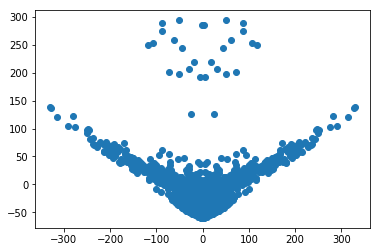

In [19]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

pca = PCA()
X_train_tr = pca.fit_transform(df_train[features])
X_test_tr = pca.transform(df_test[features])

plt.scatter(X_train_tr[:,0], X_train_tr[:,1])

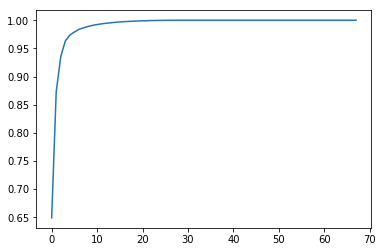

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [21]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train_tr[:, :10], df_train[target])
pred = lr.predict(X_test_tr[:, :10])
probs = lr.predict_proba(X_test_tr[:, :10])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.530938704189
RMSE:  0.17980356067
ROC AUC:  0.804939852974


#### Parameter Tuning

In [51]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

# fit means/std
ss = StandardScaler()
ss.fit(df_train[features])

params = {'penalty': ['l1', 'l2'],
          'C': np.logspace(-4.0, 4.0, num=50)
         }

lr = LogisticRegression()
lr_gs = GridSearchCV(lr, params, scoring='neg_log_loss')

lr_gs.fit(ss.transform(df_train[features]), df_train[target])
pred = lr_gs.predict(ss.transform(df_test[features]))
probs = lr_gs.predict_proba(ss.transform(df_test[features]))

print(lr_gs.best_params_)
print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

{'C': 0.18420699693267145, 'penalty': 'l1'}
             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Log Loss:  0.530934541743
RMSE:  0.179506005745
ROC AUC:  0.805622076186


### Evaluation over Baseline

Oddly enough, nothing produces better results than the default settings we tried with Logistic Regression earlier. That is with L2 Regularization and C = 1.0. This model produces an Log Loss score of 0.529, as compared to the baseline score of 0.693. 

## Modeling - Approach 2
***

The second approach to training and tuning the models is using the data from the regular season to train the model, and using the tournament data to tune the model.  An assumption with this approach is that we are treating the match up between regular season games and tournament games the same.

This approach has boths pros and cons.  One of the benefits to this approach is that many more observations to train from using the regular season games between 2003-2018 (82041) than just relying on the tournament games between 2003-2013 (713).  There are also daily rankings of division 1 teams provided by Massey Ratings which are apt for training with regular season games, although the ranking from the last regular season game can still be used with approach 1.  One of the main disadvantages to using approach 2 is that it cannot train on the tournament seed information, which is only available prior to the tournament.

Note that there are also variations for approach 2 that should be explored.  One variation is to use all the regular season games as training data, and all the tournament games as tuning data.  A second variation is to use the tournament data prior to 2014 with the regular season data for training, and the tournament data between 2014-2017 for tuning, similar to approach 1.  Both of these variations are examined below.

### Pull Features from PostgreSQL

Pull data from PostgreSQL and pickle to work offline.

In [21]:
conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

### Get the train/dev data from the database

#### Approach2: Training data is all regular season data (2003-2018)

In [22]:
approach2TrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') AND (f."Season" < 2019) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2_training = pd.read_sql_query(approach2TrainingDataQuery, conn)

#### Approach2: Dev data is all tournament data (2003-2017)

In [23]:
approach2DevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2002) AND (f."Season" < 2018) order by "Season", "DayNum", "Team" '''
df_approach2_dev = pd.read_sql_query(approach2DevDataQuery, conn)

#### Approach2 Combined: Training data is all regular season data (2003-2018) and the tournament games before 2014 (2003-2013)

In [24]:
approach2CombinedTrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') OR (f."Season" < 2014) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2Combined_training = pd.read_sql_query(approach2CombinedTrainingDataQuery, conn)

#### Approach2 Combined: Dev data is tournament data between 2014-2017

In [25]:
approach2CombinedDevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2013) AND (f."Season" < 2018) order by "Season", "DayNum", "Team" '''
df_approach2Combined_dev = pd.read_sql_query(approach2CombinedDevDataQuery, conn)

In [26]:
conn.close()

### Remove NaNs

In [27]:
columnsToClean = ['Outcome', 'AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team', 'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team', 'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team', 'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team', 'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent', 'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent', 'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent', 'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent', 'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent']
df_approach2_training.dropna(how='any', inplace=True, subset=columnsToClean)
df_approach2_dev.dropna(how='any', inplace=True, subset=columnsToClean)
df_approach2Combined_training.dropna(how='any', inplace=True, subset=columnsToClean)
df_approach2Combined_dev.dropna(how='any', inplace=True, subset=columnsToClean)

### Create Train and Dev Sets

In [28]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team', 'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team', 'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team', 'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team', 'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent', 'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent', 'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent', 'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent', 'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent']

In [29]:
X_train2 = df_approach2_training[features]
y_train2 = df_approach2_training[target]
X_dev2  = df_approach2_dev[features]
y_dev2  = df_approach2_dev[target]

In [30]:
X_train2_combined = df_approach2Combined_training[features]
y_train2_combined = df_approach2Combined_training[target]
X_dev2_combined  = df_approach2Combined_dev[features]
y_dev2_combined  = df_approach2Combined_dev[target]

#### Perform a Logistic Regression (Lasso) Using the **Regular Season**

In [16]:
lrc1 = LogisticRegression(penalty='l1')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv1 = GridSearchCV(lrc1, params, scoring='neg_log_loss', refit=True)
gscv1.fit(X_train2, y_train2)
print('Best log-loss: {:.4}, with best C: {}'.format(gscv1.best_score_, gscv1.best_params_['C']))
lrc1 = LogisticRegression(penalty='l1', C=gscv1.best_params_['C'])
lrc1.fit(X_train2, y_train2)
prediction1 = lrc1.predict(X_dev2)
y_probas = lrc1.predict_proba(X_dev2)

Best log-loss: -0.5518, with best C: 75


In [17]:
# Determine F1 score
print(classification_report(prediction1, y_dev2))
# Determine AUC
print('Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  prediction1)))
# Determine log-loss
print('Log loss: {}'.format(log_loss(y_dev2.values, y_probas[:,1])))
# Determine RMSE
print('RMSE: {}'.format(mean_squared_error(y_dev2.values, y_probas[:,1])))

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       981
          1       0.73      0.73      0.73       981

avg / total       0.73      0.73      0.73      1962

Area under the curve: 0.727
Log loss: 0.5474973854171304
RMSE: 0.1851080849969821


#### Perform a Logistic Regression (Ridge) Using the **Regular Season**

In [42]:
lrc2 = LogisticRegression(penalty='l2')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv2 = GridSearchCV(lrc2, params, scoring='neg_log_loss', refit=True)
gscv2.fit(X_train2, y_train2)
print('Best log-loss: {:.4}, with best C: {}'.format(gscv2.best_score_, gscv2.best_params_['C']))
lrc2 = LogisticRegression(penalty='l2', C=gscv2.best_params_['C'])
lrc2.fit(X_train2, y_train2)
prediction2 = lrc2.predict(X_dev2)
y_probas = lrc2.predict_proba(X_dev2)

Best log-loss: -0.5518, with best C: 150


In [43]:
# Determine F1 score
print(classification_report(prediction2, y_dev2))
# Determine AUC
print('Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  prediction2)))
# Determine log-loss
print('Log loss: {}'.format(log_loss(y_dev2.values, y_probas[:,1])))
# Determine RMSE
print('RMSE: {}'.format(mean_squared_error(y_dev2.values, y_probas[:,1])))

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       981
          1       0.73      0.73      0.73       981

avg / total       0.73      0.73      0.73      1962

Area under the curve: 0.728
Log loss: 0.547928193117
RMSE: 0.185320087108


#### Perform a Logistic Regression (Lasso) Using **Combined Regular Season / Tournament Data**

In [44]:
lrc3 = LogisticRegression(penalty='l1')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv3 = GridSearchCV(lrc3, params, scoring='neg_log_loss', refit=True)
gscv3.fit(X_train2_combined, y_train2_combined)
print('Best log-loss: {:.4}, with best C: {}'.format(gscv3.best_score_, gscv3.best_params_['C']))
lrc3 = LogisticRegression(penalty='l1', C=gscv3.best_params_['C'])
lrc3.fit(X_train2_combined, y_train2_combined)
prediction3 = lrc3.predict(X_dev2_combined)
y_probas = lrc3.predict_proba(X_dev2_combined)

Best log-loss: -0.5518, with best C: 125


In [46]:
# Determine F1 score
print(classification_report(prediction3, y_dev2_combined))
# Determine AUC
print('Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2_combined,  prediction3)))
# Determine log-loss
print('Log loss: {}'.format(log_loss(y_dev2_combined.values, y_probas[:,1])))
# Determine RMSE
print('RMSE: {}'.format(mean_squared_error(y_dev2_combined.values, y_probas[:,1])))

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Area under the curve: 0.743
Log loss: 0.536772997951
RMSE: 0.180269404758


#### Perform a Logistic Regression (Ridge) Using **Combined Regular Season / Tournament Data**

In [18]:
lrc4 = LogisticRegression(penalty='l2')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv4 = GridSearchCV(lrc4, params, scoring='neg_log_loss', refit=True)
gscv4.fit(X_train2_combined, y_train2_combined)
print('Best log-loss: {:.4}, with best C: {}'.format(gscv4.best_score_, gscv4.best_params_['C']))
lrc4 = LogisticRegression(penalty='l2', C=gscv4.best_params_['C'])
lrc4.fit(X_train2_combined, y_train2_combined)
prediction4 = lrc4.predict(X_dev2_combined)
y_probas = lrc4.predict_proba(X_dev2_combined)

Best log-loss: -0.5518, with best C: 50


In [19]:
# Determine F1 score
print(classification_report(prediction4, y_dev2_combined))
# Determine AUC
print('Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2_combined,  prediction4)))
# Determine log-loss
print('Log loss: {}'.format(log_loss(y_dev2_combined.values, y_probas[:,1])))
# Determine RMSE
print('RMSE: {}'.format(mean_squared_error(y_dev2_combined.values, y_probas[:,1])))

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Area under the curve: 0.743
Log loss: 0.5371935748903257
RMSE: 0.18048982712254258


### Best Data Set and Regularization

Based on the above models, the best results are from training a logistic regression model using a combination of regular season and tournament games (2003-2013), and using lasso regression (L1) for regularization.

## Model Ensemble
***

Rather than just using approach 1 or approach 2, it is possible to combine the two approaches into an ensemble.

The ensemble used here trains approach 1 using the tournament data (prior to 2014), and approach 2 using the combined regular season / tournament data as described above.

Then predictions are made using the tournament data from 2014-207, as this is common between the two approaches (but note that the SeedDiff feature is not used with approach 2).

The probabilities for winning from both approaches are averaged, and so are the probabilities for losing.

After averaging the probabilities, the winning and losing probabilities are then compared to see which probability is greater.  The greater probability determines the predicted outcome of the game.

In [32]:
# target = 'Outcome'
# features2 = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
#             'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
#             'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
#             'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
#             'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
#             'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
#             'AvgNetPointsFor', 'OpponentAvgPointsFor',
#             'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
#             'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
#             'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
#             'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
#             'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
#             'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
#             'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
#             'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
#             'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
#             'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent']
# features1 = features2 + ['SeedDiff']

### Train Approach 1

In [64]:
target = 'Outcome'
features1 = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

ss = StandardScaler()
ss.fit(df_train[features1])

lr1 = LogisticRegression(penalty='l2')
lr1.fit(ss.transform(df_train[features1]), df_train[target])

# fit on common dev data
pred1 = lr1.predict(ss.transform(df_test[features1]))
probs1 = lr1.predict_proba(ss.transform(df_test[features1]))

print(classification_report(df_test[target], pred1))
print("Log Loss: ",log_loss(df_test[target], probs1[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs1[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs1[:,1]))

             precision    recall  f1-score   support

          0       0.76      0.76      0.76       268
          1       0.76      0.76      0.76       268

avg / total       0.76      0.76      0.76       536

Log Loss:  0.529461957644
RMSE:  0.178672013288
ROC AUC:  0.808810425485


### Train Approach 2

In [65]:
target = 'Outcome'
features2 = list(X_dev2_combined.columns)

lr2 = LogisticRegression(penalty='l1', C=125)
lr2.fit(X_train2_combined, y_train2_combined)

# fit on common dev data
pred2 = lr2.predict(df_test[features2])
probs2 = lr2.predict_proba(df_test[features2])

print(classification_report(df_test[target], pred2))
print("Log Loss: ",log_loss(df_test[target], probs2[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs2[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs2[:,1]))

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Log Loss:  0.536758492226
RMSE:  0.180263171259
ROC AUC:  0.811205168189


### Simple Ensemble of Approach 1 and Approach 2

In [66]:
# Get the mean of the loss probabilities and the win probabilities
loss_prob_df = pd.DataFrame(data={'approach1':probs1[:,0], 'approach2':probs2[:,0]})
win_prob_df = pd.DataFrame(data={'approach1':probs1[:,1], 'approach2':probs2[:,1]})
loss_win_df = pd.DataFrame(data={'loss_prob':loss_prob_df.mean(axis=1), 'win_prob':win_prob_df.mean(axis=1), 'predict':0})

In [67]:
# Determine loss / win depending on which probability is larger
ensemble_predictions = []
ensemble_probs = []

for index in range(len(win_prob_df)):
    if loss_win_df['loss_prob'][index] > loss_win_df['win_prob'][index] :
        ensemble_predictions.append(0)
        ensemble_probs.append(1-loss_win_df['loss_prob'][index])
    else:
        ensemble_predictions.append(1)
        ensemble_probs.append(loss_win_df['win_prob'][index])

In [68]:
print(classification_report(df_test[target], ensemble_predictions))
print("Log Loss: ",log_loss(df_test[target], ensemble_probs))
print("RMSE: ",mean_squared_error(df_test[target], ensemble_probs))
print("ROC AUC: ", roc_auc_score(df_test[target], ensemble_probs))

             precision    recall  f1-score   support

          0       0.75      0.75      0.75       268
          1       0.75      0.75      0.75       268

avg / total       0.75      0.75      0.75       536

Log Loss:  0.523652468758
RMSE:  0.175790465405
ROC AUC:  0.815994653598


### Weighted Ensemble with Logistic Regression

In [124]:
# df_ens_dev, df_ens_test = train_test_split(df_test)
df_ens_dev = df_test[df_test['Season'] < 2017]
df_ens_test = df_test[df_test['Season'] == 2017]

# fit ens_dev
# a1
pred1_ens_dev = lr1.predict(ss.transform(df_ens_dev[features1]))
probs1_ens_dev = lr1.predict_proba(ss.transform(df_ens_dev[features1]))

# a2
pred2_ens_dev = lr2.predict(df_ens_dev[features2])
probs2_ens_dev = lr2.predict_proba(df_ens_dev[features2])

# prediction probabilities into features
X_ens_dev = np.asarray((probs1_ens_dev[:, 1],probs2_ens_dev[:, 1])).T

# fit ens_dev prediction probs
ens1 = LogisticRegression()
ens1.fit(X_ens_dev, df_ens_dev[target])

# fit ens_test
# a1
pred1_ens_test = lr1.predict(ss.transform(df_ens_test[features1]))
probs1_ens_test = lr1.predict_proba(ss.transform(df_ens_test[features1]))

# a2
pred2_ens_test = lr2.predict(df_ens_test[features2])
probs2_ens_test = lr2.predict_proba(df_ens_test[features2])

# prediction probabilities into features
X_ens_test = np.asarray((probs1_ens_test[:, 1],probs2_ens_test[:, 1])).T

# predict ens_test probabilities
pred_fin = ens1.predict(X_ens_test)
probs_fin = ens1.predict_proba(X_ens_test)

print(classification_report(df_ens_test[target], pred_fin))
print("Log Loss: ",log_loss(df_ens_test[target], probs_fin[:,1]))
print("RMSE: ",mean_squared_error(df_ens_test[target], probs_fin[:,1]))
print("ROC AUC: ", roc_auc_score(df_ens_test[target], probs_fin[:,1]))

             precision    recall  f1-score   support

          0       0.77      0.76      0.77        67
          1       0.76      0.78      0.77        67

avg / total       0.77      0.77      0.77       134

Log Loss:  0.515845272942
RMSE:  0.171587089873
ROC AUC:  0.828469592337


## Final Model Evaluation (2018 Tournament)
***

### Pull All Potential 2018 Matchups

This includes both games that did and did not actually occur. Using the top performing methods, data will be retrained using both training and dev data from the earlier section and finally tested on 2018 data. Final results were not shared in tabular form from Kaggle, since the competition ended. Data was [scraped](http://www.google.com) from NCAA website.

In [11]:
# pull 2018 potential matchups
query = '''
    SELECT *
    FROM prod.features
    WHERE "Season Type" = 'NCAA Tourney' and
        holdout_s2 = 1
'''

conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

df_2018 = pd.read_sql_query(query, conn)

# "Diff" Features
df_2018['AvgRankDiff'] = df_2018['AvgRank'] - df_2018['OpponentAvgRank']
df_2018['AvgNetPointsForDiff'] = df_2018['AvgNetPointsFor'] - df_2018['OpponentAvgNetPointsFor']
df_2018['TwoPointPctDiff'] = df_2018['TwoPointPct_Team'] - df_2018['TwoPointPct_Opponent']
df_2018['ThreePointPctDiff'] = df_2018['ThreePointPct_Team'] - df_2018['ThreePointPct_Opponent']
df_2018['FreeThrowPctDiff'] = df_2018['FreeThrowPct_Team'] - df_2018['FreeThrowPct_Opponent']
df_2018['OffensiveReboundsDiff'] = df_2018['OffensiveRebounds_Team'] - df_2018['OffensiveRebounds_Opponent']
df_2018['DefensiveReboundsDiff'] = df_2018['DefensiveRebounds_Team'] - df_2018['DefensiveRebounds_Opponent']
df_2018['FieldGoalPctDiff'] = df_2018['FieldGoalPct_Team'] - df_2018['FieldGoalPct_Opponent']
df_2018['TwoPointAttPctDiff'] = df_2018['TwoPointAttPct_Team'] - df_2018['TwoPointAttPct_Opponent']
df_2018['ThreePointAttPctDiff'] = df_2018['ThreePointAttPct_Team'] - df_2018['ThreePointAttPct_Opponent']
df_2018['FieldGoalAttDiff'] = df_2018['FieldGoalAtt_Team'] - df_2018['FieldGoalAtt_Opponent']
df_2018['TwoPointAttDiff'] = df_2018['TwoPointAtt_Team'] - df_2018['TwoPointAtt_Opponent']
df_2018['ThreePointAttDiff'] = df_2018['ThreePointAtt_Team'] - df_2018['ThreePointAtt_Opponent']
df_2018['FreeThrowAttDiff'] = df_2018['FreeThrowAtt_Team'] - df_2018['FreeThrowAtt_Opponent']
df_2018['AssistsDiff'] = df_2018['Assists_Team'] - df_2018['Assists_Opponent']
df_2018['TurnoversDiff'] = df_2018['Turnovers_Team'] - df_2018['Turnovers_Opponent']
df_2018['StealsDiff'] = df_2018['Steals_Team'] - df_2018['Steals_Opponent']
df_2018['BlocksDiff'] = df_2018['Blocks_Team'] - df_2018['Blocks_Opponent']
df_2018['PersonalFoulsDiff'] = df_2018['PersonalFouls_Team'] - df_2018['PersonalFouls_Opponent']

df_2018.shape

(4556, 83)

Filter to only games that occurred for testing.

In [12]:
df_test_2018 = df_2018[df_2018['Outcome'].notnull()]
print(df_test_2018.shape)

(134, 83)


### Baseline

Just to reground ourselves -- these are the log-loss scores for the baseline.

In [13]:
target = 'Outcome'

# baseline of 0.5
baseline = np.full(134, 0.5)
print("Baseline: ",log_loss(df_test_2018[target],baseline))

# worst case scenario -- every prediction was wrong with 100% confidence
print("Completely Wrong: ",log_loss(df_test_2018[target],1-df_test_2018[target]))

Baseline:  0.69314718056
Completely Wrong:  34.5391761936


- Kaggle "Starter" Kernel

In [14]:
target = 'Outcome'
features = ['SeedDiff']

lr = LogisticRegression()
lr.fit(df_in[features], df_in[target])

pred = lr.predict(df_test_2018[features])
probs = lr.predict_proba(df_test_2018[features])

print(classification_report(df_test_2018[target], pred))
print("Log Loss: ",log_loss(df_test_2018[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test_2018[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test_2018[target], probs[:,1]))

             precision    recall  f1-score   support

        0.0       0.68      0.63      0.65        67
        1.0       0.65      0.70      0.68        67

avg / total       0.67      0.66      0.66       134

Log Loss:  0.606663707033
RMSE:  0.208931700066
ROC AUC:  0.734127868122


### Best Approach 1

Logistic Regression with L2 Regularization and C = 1.0

In [131]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

# fit means/std
ss = StandardScaler()
ss.fit(df_in[features])

lr = LogisticRegression(penalty='l2')
lr.fit(ss.transform(df_in[features]), df_in[target])

pred = lr.predict(ss.transform(df_test_2018[features]))
probs = lr.predict_proba(ss.transform(df_test_2018[features]))

print(classification_report(df_test_2018[target], pred))
print("Log Loss: ",log_loss(df_test_2018[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test_2018[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test_2018[target], probs[:,1]))

             precision    recall  f1-score   support

        0.0       0.70      0.70      0.70        67
        1.0       0.70      0.70      0.70        67

avg / total       0.70      0.70      0.70       134

Log Loss:  0.609581060519
RMSE:  0.201148927619
ROC AUC:  0.761639563377


### Best Approach 2

In [145]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent',
            'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent',
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst',
            'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff',
            'FieldGoalPct_Team', 'TwoPointAttPct_Team', 'ThreePointAttPct_Team',
            'FieldGoalAtt_Team', 'TwoPointAtt_Team', 'ThreePointAtt_Team', 'FreeThrowAtt_Team',
            'Assists_Team', 'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent', 'ThreePointAttPct_Opponent',
            'FieldGoalAtt_Opponent', 'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent', 'Steals_Opponent',
            'Blocks_Opponent', 'PersonalFouls_Opponent']

X_train2_final = np.concatenate((X_train2_combined, X_dev2_combined))
y_train2_final = np.concatenate((y_train2_combined, y_dev2_combined))

lr2 = LogisticRegression(penalty='l1', C=125)
lr2.fit(X_train2_final, y_train2_final)

# fit on common dev data
pred2 = lr2.predict(df_test_2018[features])
probs2 = lr2.predict_proba(df_test_2018[features])

print(classification_report(df_test_2018[target], pred2))
print("Log Loss: ",log_loss(df_test_2018[target], probs2[:,1]))
print("RMSE: ",mean_squared_error(df_test_2018[target], probs2[:,1]))
print("ROC AUC: ", roc_auc_score(df_test_2018[target], probs2[:,1]))

             precision    recall  f1-score   support

        0.0       0.63      0.63      0.63        67
        1.0       0.63      0.63      0.63        67

avg / total       0.63      0.63      0.63       134

Log Loss:  0.58819540517
RMSE:  0.203892308624
ROC AUC:  0.746045889953


### Simple Ensemble

In [146]:
# Get the mean of the loss probabilities and the win probabilities
loss_prob_df = pd.DataFrame(data={'approach1':probs[:,0],
                                  'approach2':probs2[:,0]
                                 })
win_prob_df = pd.DataFrame(data={'approach1':probs[:,1],
                                 'approach2':probs2[:,1]
                                })
loss_win_df = pd.DataFrame(data={'loss_prob':loss_prob_df.mean(axis=1),
                                 'win_prob':win_prob_df.mean(axis=1),
                                 'predict':0
                                })

# Determine loss / win depending on which probability is larger
ensemble_predictions = []
ensemble_probs = []

for index in range(len(win_prob_df)):
    if loss_win_df['loss_prob'][index] > loss_win_df['win_prob'][index] :
        ensemble_predictions.append(0)
        ensemble_probs.append(1-loss_win_df['loss_prob'][index])
    else:
        ensemble_predictions.append(1)
        ensemble_probs.append(loss_win_df['win_prob'][index])
        
print(classification_report(df_test_2018[target], ensemble_predictions))
print("Log Loss: ",log_loss(df_test_2018[target], ensemble_probs))
print("RMSE: ",mean_squared_error(df_test_2018[target], ensemble_probs))
print("ROC AUC: ", roc_auc_score(df_test_2018[target], ensemble_probs))

             precision    recall  f1-score   support

        0.0       0.67      0.67      0.67        67
        1.0       0.67      0.67      0.67        67

avg / total       0.67      0.67      0.67       134

Log Loss:  0.587896342483
RMSE:  0.200916557467
ROC AUC:  0.75762976164


### Weighted Ensemble

For each approach, data needs to be split into three groups.

1. Training
2. Ensemble Training
3. Test (2018)

Ensemble Training data examples must be homogenous between approach 1 and approach 2, although this is not necessarily the case for the first stage of training. There are simply two features in Ensemble Training, predicted probabilities from each approach.

#### Split Data

In [184]:
# combine dev/train for approach 2
# approach1 is pulled in together
df_train_a2 = pd.concat((df_approach2Combined_training, df_approach2Combined_dev))

# first level training
df_train1_a1 = df_in[df_in['Season'] < 2017]
df_train1_a2 = df_train_a2[(df_train_a2['Season Type'] == 'Regular') | (df_train_a2['Season'] < 2017)]

# second level training -- same dataset for both approaches
df_train2 = df_in[df_in['Season'] == 2017]

# Just to check observations
df_train1_a2 = df_train_a2[(df_train_a2['Season Type'] == 'Regular') | (df_train_a2['Season'] < 2017)]
df_train2_a2 = df_train_a2[(df_train_a2['Season Type'] == 'NCAA Tourney') & (df_train_a2['Season'] == 2017)]

print(df_train1_a1.shape)
print(df_train2.shape)
print(df_train1_a2.shape)
print(df_train2_a2.shape)
print(df_test_2018.shape)


(1828, 83)
(134, 83)
(154722, 64)
(134, 64)
(134, 83)


#### Fit Approach 1

In [185]:
target = 'Outcome'
features1 = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

# fit means/std
ss = StandardScaler()
ss.fit(df_train1_a1[features1])

lr1 = LogisticRegression(penalty='l2')
lr1.fit(ss.transform(df_train1_a1[features1]), df_train1_a1[target])

# predict "dev"
pred1 = lr.predict(ss.transform(df_train2[features1]))
probs1 = lr.predict_proba(ss.transform(df_train2[features1]))

# predict on "2018 test"
pred1_2018 = lr.predict(ss.transform(df_test_2018[features1]))
probs1_2018 = lr.predict_proba(ss.transform(df_test_2018[features1]))

#### Fit Approach 2

In [181]:
target = 'Outcome'
features2 = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent',
            'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent',
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst',
            'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff',
            'FieldGoalPct_Team', 'TwoPointAttPct_Team', 'ThreePointAttPct_Team',
            'FieldGoalAtt_Team', 'TwoPointAtt_Team', 'ThreePointAtt_Team', 'FreeThrowAtt_Team',
            'Assists_Team', 'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent', 'ThreePointAttPct_Opponent',
            'FieldGoalAtt_Opponent', 'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent', 'Steals_Opponent',
            'Blocks_Opponent', 'PersonalFouls_Opponent']

lr2 = LogisticRegression(penalty='l1', C=125)
lr2.fit(df_train1_a2[features2], df_train1_a2[target])

# predict "dev"
pred2 = lr2.predict(df_train2[features2])
probs2 = lr2.predict_proba(df_train2[features2])

# predict "2018 test"
pred2_2018 = lr2.predict(df_test_2018[features2])
probs2_2018 = lr2.predict_proba(df_test_2018[features2])

#### Fit Weighted Ensemble

In [183]:
# ensemble features
X_ens_train = np.asarray((probs1[:, 1],probs2[:, 1])).T
X_ens_2018 = np.asarray((probs1_2018[:, 1],probs2_2018[:, 1])).T

# fit ensemble features
ens1 = LogisticRegression()
ens1.fit(X_ens_train, df_train2[target])

# predict 2018
pred_ens = ens1.predict(X_ens_2018)
probs_ens = ens1.predict_proba(X_ens_2018)

print(classification_report(df_test_2018[target], pred_ens))
print("Log Loss: ",log_loss(df_test_2018[target], probs_ens[:,1]))
print("RMSE: ",mean_squared_error(df_test_2018[target], probs_ens[:,1]))
print("ROC AUC: ", roc_auc_score(df_test_2018[target], probs_ens[:,1]))

             precision    recall  f1-score   support

        0.0       0.67      0.67      0.67        67
        1.0       0.67      0.67      0.67        67

avg / total       0.67      0.67      0.67       134

Log Loss:  0.58410907089
RMSE:  0.199951894606
ROC AUC:  0.75696146135


## Model Deployment
***

- Create prediction output of all possible games
- Submit CSV to Kaggle

Final predictions on all potential matchups, instead of only observed games.

In [196]:
# final predictions
probs1_final = lr.predict_proba(ss.transform(df_2018[features1]))
probs2_final = lr2.predict_proba(df_2018[features2])
X_ens_final = np.asarray((probs1_final[:, 1],probs2_final[:, 1])).T
probs_ens_final = ens1.predict_proba(X_ens_final)

(4556, 2)

In [198]:
out = df_2018[['Season', 'Team', 'Opponent']].copy()
out['Pred'] = probs_ens_final[:, 1]
out2 = out[out['Team'] < out['Opponent']]

datarows = []
for i in out2.itertuples(index=False):
    row = ("_".join([str(i.Season), str(i.Team), str(i.Opponent)]), float(i.Pred))
    datarows.append(row)

with open('./model_deployment.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['ID','Pred'])
    for row in datarows:
        csv_out.writerow(row)

## Summary
***

| Important Idea       | Relative contribution to the results (Minor, Moderate, Major) |
|----------------------|---------------------------------------------------------------|
| Classifier selection | Moderate                                                      |
| Approach 1           | Moderate                                                      |
| Approach 2           | Moderate                                                      |
| Model ensemble       | Minor                                                         |
| Base Features        | Minor                                                         |
| Engineered Features  | Major                                                         |

## Appendix

### Appendix: EDA

Below is additional exploratory data analysis that we performed.  For several of the individual features in this section, the correlation with game outcome was lower than for other features we examined in our main exploratory data analysis.

### Relationship between All Features and Target (Game Outcome)

Here are the top features that correlate with a regular season win:

In [30]:
target = ['Outcome']
features = ['Season Type', 'AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
       'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
       'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
       'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
       'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
       'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
       'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
       'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
       'OpponentTourWins', 'TourWinsDiff', 'cum_wins_v_opp',
       'cum_games_v_opp', 'cum_winpct_v_opp', 'FieldGoalPct_Team',
       'TwoPointAttPct_Team', 'ThreePointAttPct_Team', 'FieldGoalAtt_Team',
       'TwoPointAtt_Team', 'ThreePointAtt_Team', 'FreeThrowAtt_Team',
       'Assists_Team', 'Turnovers_Team', 'Steals_Team', 'Blocks_Team',
       'PersonalFouls_Team', 'FieldGoalPct_Opponent',
       'TwoPointAttPct_Opponent', 'ThreePointAttPct_Opponent',
       'FieldGoalAtt_Opponent', 'TwoPointAtt_Opponent',
       'ThreePointAtt_Opponent', 'FreeThrowAtt_Opponent',
       'Assists_Opponent', 'Turnovers_Opponent', 'Steals_Opponent',
       'Blocks_Opponent', 'PersonalFouls_Opponent'
           ]

cm = df_reg[target+features].corr()['Outcome'].abs().sort_values(ascending=False)
cm_df_pretty = pd.DataFrame(cm.head(11))

cm_df_pretty

,Outcome
Outcome,1.000000
WinPctDiff,0.396641
OpponentAvgRank,0.268173
AvgRank,0.268173
AvgNetPointsFor,0.266428
OpponentAvgNetPointsFor,0.266428
OpponentWinPct,0.252097
WinPct,0.252097
cum_winpct_v_opp,0.247859
TourWinsDiff,0.237438


Here are the top features that correlate with a tournament win:

In [31]:
target = ['Outcome']
features = ['Season Type', 'AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
       'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
       'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
       'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
       'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
       'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
       'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
       'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
       'OpponentTourWins', 'TourWinsDiff', 'cum_wins_v_opp',
       'cum_games_v_opp', 'cum_winpct_v_opp', 'FieldGoalPct_Team',
       'TwoPointAttPct_Team', 'ThreePointAttPct_Team', 'FieldGoalAtt_Team',
       'TwoPointAtt_Team', 'ThreePointAtt_Team', 'FreeThrowAtt_Team',
       'Assists_Team', 'Turnovers_Team', 'Steals_Team', 'Blocks_Team',
       'PersonalFouls_Team', 'FieldGoalPct_Opponent',
       'TwoPointAttPct_Opponent', 'ThreePointAttPct_Opponent',
       'FieldGoalAtt_Opponent', 'TwoPointAtt_Opponent',
       'ThreePointAtt_Opponent', 'FreeThrowAtt_Opponent',
       'Assists_Opponent', 'Turnovers_Opponent', 'Steals_Opponent',
       'Blocks_Opponent', 'PersonalFouls_Opponent'
           ]

cm = df_tour[target+features].corr()['Outcome'].abs().sort_values(ascending=False)
cm_df_pretty = pd.DataFrame(cm.head(11))

cm_df_pretty

,Outcome
Outcome,1.000000
SeedDiff,0.496188
TourWinsDiff,0.386137
WinPctDiff,0.351707
AvgRank,0.321558
OpponentAvgRank,0.321558
AvgNetPointsFor,0.308995
OpponentAvgNetPointsFor,0.308995
OpponentTourWins,0.277334
TourWins,0.277334


### Broad Correlation Matrix and Heatmap

Here is a broad visual representation of the correlation between individual features, followed by a heatmap.  To limit multi-collinearity between independent variables, we want to limit the use of pairs / sets of variables that show a linear relationshp with one another.

#### Broad Correlation Matrix

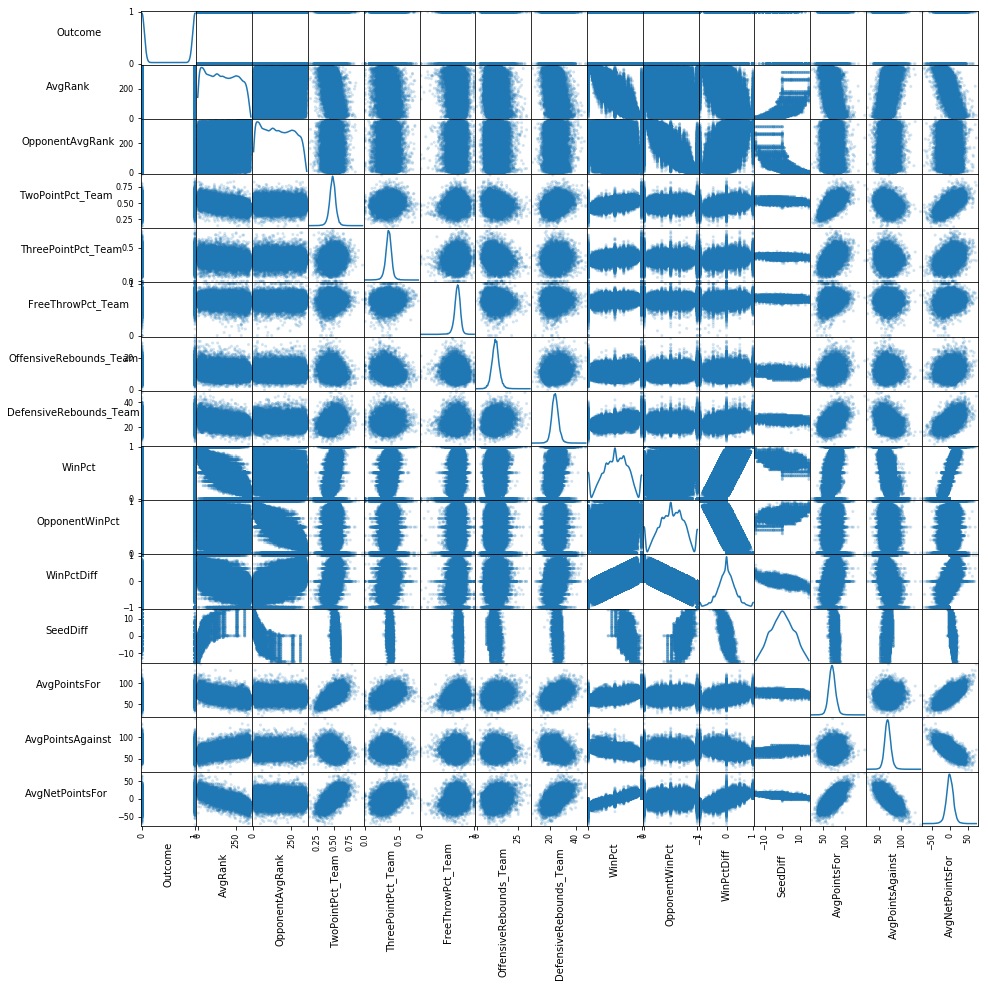

In [14]:
target = ['Outcome']
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team',
            'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team',
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'SeedDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

axs = pd.plotting.scatter_matrix(df[target+features], alpha=0.2, figsize=(15, 15), diagonal='kde')
n = len(df[target+features].columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

#### Broad Correlation Heatmap

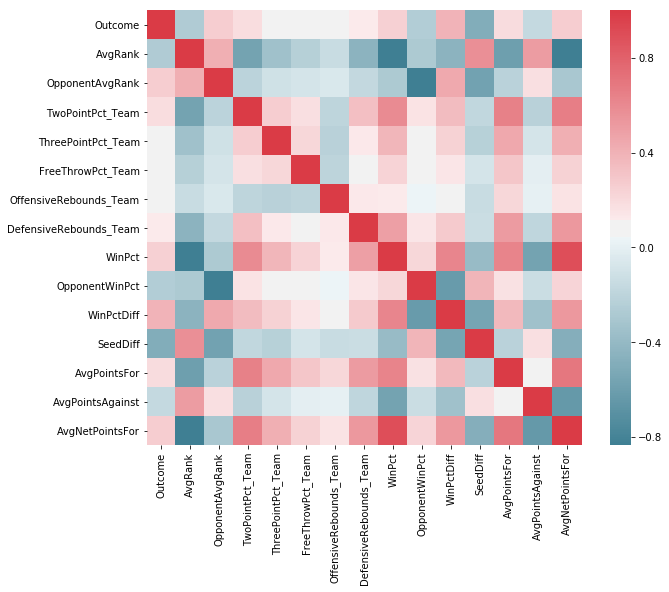

In [15]:
target = ['Outcome']
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team',
            'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team',
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'SeedDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

cm = df[target+features].corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, mask=np.zeros_like(cm, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### Game Statistics: Free Throw Percentage

### Regular Season

In [188]:
df_reg[['FreeThrowPct_Team']].describe()

,FreeThrowPct_Team
count,148142.000000
mean,0.682886
std,0.056036
min,0.000000
25%,0.651078
50%,0.685591
75%,0.717949
max,1.000000


In [189]:
df_winners = df_reg[df_reg.Outcome == 1]
df_winners[['FreeThrowPct_Team', 'FreeThrowPct_Opponent']].describe()

,FreeThrowPct_Team,FreeThrowPct_Opponent
count,74108.000000,74034.000000
mean,0.686805,0.678964
std,0.054181,0.057566
min,0.000000,0.000000
25%,0.655362,0.647058
50%,0.689087,0.681768
75%,0.720997,0.714623
max,1.000000,1.000000


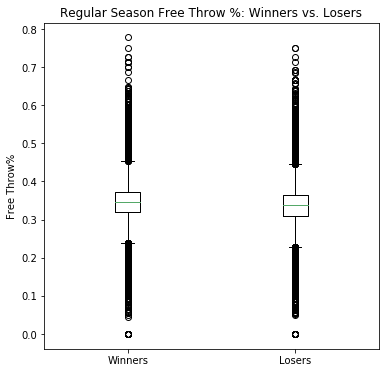

In [190]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Regular Season Free Throw %: Winners vs. Losers')
_ = plt.boxplot([df_winners.ThreePointPct_Team.dropna(),df_winners.ThreePointPct_Opponent.dropna()])
_ = ax1.set_ylabel('Free Throw%')
_ = ax1.set_xticklabels(['Winners','Losers'])

#### Two Independent Samples T-Test

In [191]:
t, p = ttest_ind(df_winners['FreeThrowPct_Team'].dropna(), df_winners['FreeThrowPct_Opponent'].dropna(), equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 27.00  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [192]:
df_corr = pd.DataFrame({'Outcome':df_reg['Outcome']})
df_corr['FreeThrowDifference'] = df_reg['FreeThrowPct_Team'] - df_reg['FreeThrowPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.10


### Tournament

In [193]:
df_tour[['FreeThrowPct_Team']].describe()

,FreeThrowPct_Team
count,1962.000000
mean,0.703727
std,0.037091
min,0.580619
25%,0.679251
50%,0.701993
75%,0.728992
max,0.816726


In [194]:
df_winners = df_tour[df_tour.Outcome == 1]
df_winners[['FreeThrowPct_Team', 'FreeThrowPct_Opponent']].describe()

,FreeThrowPct_Team,FreeThrowPct_Opponent
count,981.000000,981.000000
mean,0.704863,0.702590
std,0.037246,0.036919
min,0.587035,0.580619
25%,0.681387,0.676196
50%,0.702317,0.701952
75%,0.730715,0.727466
max,0.816726,0.816726


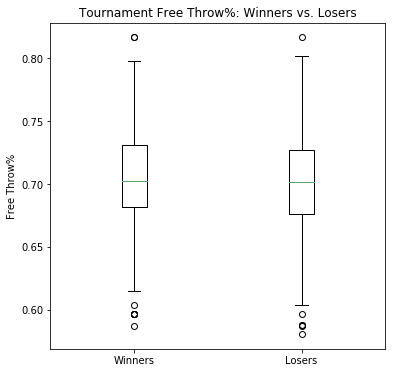

In [196]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Tournament Free Throw%: Winners vs. Losers')
_ = plt.boxplot([df_winners.FreeThrowPct_Team.dropna(),df_winners.FreeThrowPct_Opponent.dropna()])
_ = ax1.set_ylabel('Free Throw%')
_ = ax1.set_xticklabels(['Winners','Losers'])

#### Two Independent Samples T-Test

In [197]:
t, p = ttest_ind(df_winners['FreeThrowPct_Team'].dropna(), df_winners['FreeThrowPct_Opponent'].dropna(), equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 1.36  p = 0.1749


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [198]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['FreeThrowDifference'] = df_tour['FreeThrowPct_Team'] - df_tour['FreeThrowPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.04


### Regular Season vs. Tournament

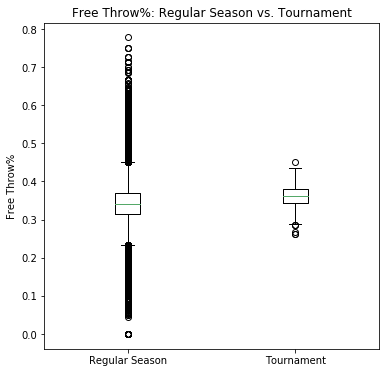

In [199]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Free Throw%: Regular Season vs. Tournament')
_ = plt.boxplot([df_reg.ThreePointPct_Team.dropna(),df_tour.ThreePointPct_Team.dropna()])
_ = ax1.set_ylabel('Free Throw%')
_ = ax1.set_xticklabels(['Regular Season','Tournament'])

### Analysis

The mean free throw shooting percent for the regular season is 68.3% whereas the mean two point shooting percent in the tournament is 70.4%, so the free throw shooting percentage is better for tournament teams, which makes sense.  Not only is the mean higher, the variance is also much smaller.

For the regular season, the difference between the mean free throw shooting percentage of winning teams (68.7%) v. losing teams (67.9%) is about 0.8%, and is statistically significant. The correlation between the free throw shooting of the teams and the outcome of the game (win/lose) is 0.10, which indicates a very weak linear relationship.

For the tournament, the difference between the mean free throw shooting percentage of winning teams (70.5%) v. losing teams (70.3%) is about 0.2%, which is small and it is statistically insignificant (p=0.1749). The correlation between the free throw shooting of the teams and the outcome of the game (win/lose) is 0.04, which indicates no linear relationship.

### Game Statistics: Cumulative Games vs. Opponent

This feature looks at the number of cumulative games before a given day vs. a particular opponent (since 2003).

### Regular Season

In [36]:
df_reg[['cum_games_v_opp']].describe()

,cum_games_v_opp
count,164082.000000
mean,7.918199
std,8.757194
min,0.000000
25%,1.000000
50%,4.000000
75%,13.000000
max,42.000000


In [59]:
se_reg = float(np.std(df_reg[['cum_games_v_opp']])) / ((len(df_reg[['cum_games_v_opp']])) ** (0.5))

print "The standard error is: ", se_reg

The standard error is:  0.0216188784803


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACB7F7EBE0>]],
      dtype=object)

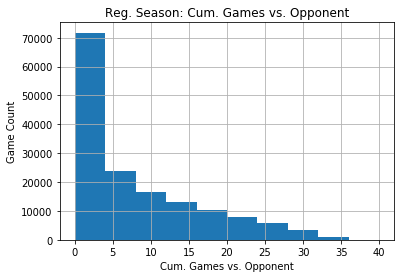

In [95]:
df_reg[['cum_games_v_opp']].hist()

graph = plt.title('Reg. Season: Cum. Games vs. Opponent')
graph = plt.xlabel('Cum. Games vs. Opponent')
graph = plt.ylabel('Game Count')

#### Correlation Between Cumulative Games vs. Opponent and Outcome

In [95]:
df_corr = pd.DataFrame({'Outcome':df_reg['Outcome']})
df_corr['cum_games_v_opp'] = df_reg['cum_games_v_opp']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0, 1])

The correlation is: 0.00


### Tournament

In [57]:
df_tour[['cum_games_v_opp']].describe()

,cum_games_v_opp
count,6518.000000
mean,1.622584
std,4.611857
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,38.000000


In [61]:
se_tour = float(np.std(df_tour[['cum_games_v_opp']])) / ((len(df_tour[['cum_games_v_opp']])) ** (0.5))

print "The standard error is: ", se_tour

The standard error is:  0.057119627001


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACBB548908>]],
      dtype=object)

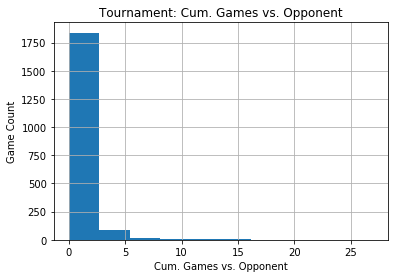

In [96]:
df_tour[['cum_games_v_opp']].hist()

graph = plt.title('Tournament: Cum. Games vs. Opponent')
graph = plt.xlabel('Cum. Games vs. Opponent')
graph = plt.ylabel('Game Count')

#### Correlation Between Cumulative Games vs. Opponent and Outcome

In [94]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['cum_games_v_opp'] = df_tour['cum_games_v_opp']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0, 1])

The correlation is: 0.00


### Regular Season vs. Tournament

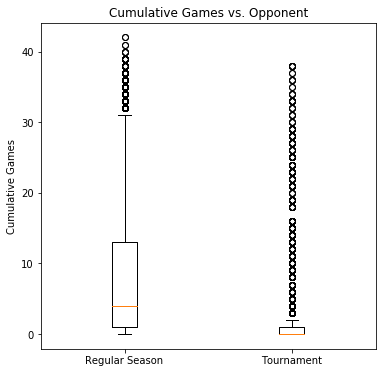

In [72]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Cumulative Games vs. Opponent')
_ = plt.boxplot([df_reg.cum_games_v_opp.dropna(), df_tour.cum_games_v_opp.dropna()])
_ = ax1.set_ylabel('Cumulative Games')
_ = ax1.set_xticklabels(['Regular Season','Tournament'])

### Analysis

The mean cumulative games since 2003 vs. a particular opponent in the regular season is 7.9, and is 1.6 during the tournament.  Given that specific teams in the tournament will have faced each other less frequently, this decline in absolute terms makes sense.  Unsurprinsgly, there is a large amount of rightward skew for cumulative games during the regular season as teams normally play opponents that are geographically closer to them more frequently.  However, there is even more rightward skew for cumulative games during the tournament as many of the same teams reach the tournament across seasons, and similarly many teams never reach the tournament.  This creates a much smaller, and frequently matched group of teams in the tournament data set.

The increase in standard error from the regular season (0.022) to the tournament (0.057) is due primarily to the effect of the smaller sample size of the tournament vs. the regular season outweighing the effect of the smaller standard deviation of the tournament vs. the regular season.

Because of the lack of correlation between the cumulative games vs. a particular opponent and the outcome of games, this feature will provide little benefit to the model.

### Game Statistics: Cumulative Wins vs. Opponent

This feature looks at the number of cumulative wins before a given day vs. a particular opponent (since 2003).

### Regular Season

In [82]:
df_reg[['cum_wins_v_opp']].describe()

,cum_wins_v_opp
count,164082.000000
mean,3.959100
std,4.935943
min,0.000000
25%,0.000000
50%,2.000000
75%,6.000000
max,35.000000


In [83]:
se_reg = float(np.std(df_reg[['cum_wins_v_opp']])) / ((len(df_reg[['cum_wins_v_opp']])) ** (0.5))

print "The standard error is: ", se_reg

The standard error is:  0.0121853587777


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACBB879D30>]],
      dtype=object)

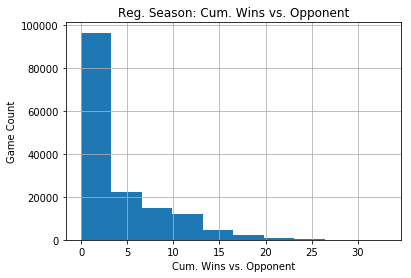

In [97]:
df_reg[['cum_wins_v_opp']].hist()

graph = plt.title('Reg. Season: Cum. Wins vs. Opponent')
graph = plt.xlabel('Cum. Wins vs. Opponent')
graph = plt.ylabel('Game Count')

#### Correlation Between Cumulative Wins vs. Opponent and Outcome

In [93]:
df_corr = pd.DataFrame({'Outcome':df_reg['Outcome']})
df_corr['cum_wins_v_opp'] = df_reg['cum_wins_v_opp']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0, 1])

The correlation is: 0.08


### Tournament

In [86]:
df_tour[['cum_wins_v_opp']].describe()

,cum_wins_v_opp
count,6518.000000
mean,0.811292
std,2.542198
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,33.000000


In [87]:
se_tour = float(np.std(df_tour[['cum_wins_v_opp']])) / ((len(df_tour[['cum_wins_v_opp']])) ** (0.5))

print "The standard error is: ", se_tour

The standard error is:  0.0314861051388


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACBB879F28>]],
      dtype=object)

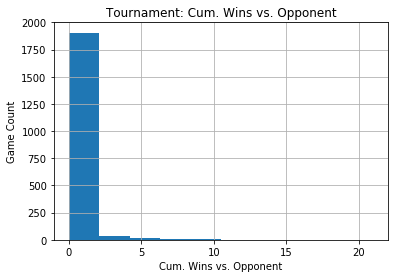

In [98]:
df_tour[['cum_wins_v_opp']].hist()

graph = plt.title('Tournament: Cum. Wins vs. Opponent')
graph = plt.xlabel('Cum. Wins vs. Opponent')
graph = plt.ylabel('Game Count')

#### Correlation Between Cumulative Wins vs. Opponent and Outcome

In [92]:
df_corr = pd.DataFrame({'Outcome':df_tour['Outcome']})
df_corr['cum_wins_v_opp'] = df_tour['cum_wins_v_opp']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0, 1])

The correlation is: 0.04


### Regular Season vs. Tournament

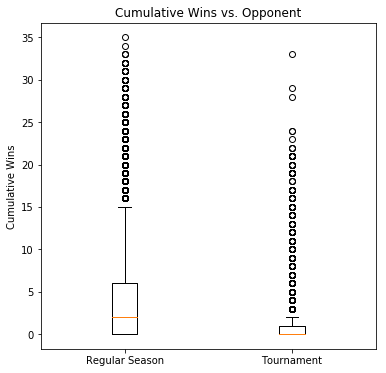

In [91]:
fig, ax1 = plt.subplots(figsize=(6, 6))
_ = plt.title('Cumulative Wins vs. Opponent')
_ = plt.boxplot([df_reg.cum_wins_v_opp.dropna(), df_tour.cum_wins_v_opp.dropna()])
_ = ax1.set_ylabel('Cumulative Wins')
_ = ax1.set_xticklabels(['Regular Season','Tournament'])

### Analysis

The mean cumulative wins since 2003 vs. a particular opponent in the regular season is 4.0, and is 0.8 during the tournament.  Given that specific teams in the tournament will have faced each other less frequently, this decline in absolute terms makes sense.  Additionally, these means are approximately half the value of the means for cumulative games played.


Unsurprinsgly, there is a large amount of rightward skew for cumulative wins during the regular season as teams normally play opponents that are geographically closer to them more frequently.  However, there is even more rightward skew for cumulative games during the tournament as many of the same teams reach the tournament across seasons, and similarly many teams never reach the tournament.  This creates a much smaller, and frequently matched group of teams in the tournament data set.  Additionally, the skew seen is even greater than that for cumulative games played, which makes sense as certain teams are likely to win more due to skill.

The increase in standard error from the regular season (0.012) to the tournament (0.031) is due primarily to the effect of the smaller sample size of the tournament vs. the regular season outweighing the effect of the smaller standard deviation of the tournament vs. the regular season.

Because of the small degree of correlation between the cumulative wins vs. a particular opponent and the outcome of games (0.08 for the regular season, and 0.04 for the tournament), this feature will provide little benefit to the model.